In [10]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Matplotlib/Seaborn imports
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D

# Plotly imports
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from plotly.colors import qualitative, sequential, diverging
import plotly.offline as pyo

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Plotly configuration
PLOTLY_THEME = "plotly_white"
PLOTLY_COLOR_SEQUENCE = px.colors.qualitative.Set2

class CriterionAnalyzer:
    def __init__(self, json_file: str = "newresults.json", theme: str = "default"):
        """
        Focused Criterion Benchmark Analyzer with separate plot functions.
        
        Args:
            json_file: Path to criterion JSON output (default: "newresults.json")
            theme: Visual theme ('default', 'dark', 'minimal', 'publication')
        """
        self.json_file = Path(json_file)
        self.theme = theme
        self.raw_data = self._load_raw_data()
        self.samples_df = self._parse_raw_samples()
        self.summary_df = self._calculate_summary_stats()
        self.comparisons_df = self._calculate_pairwise_comparisons()
        
        # Configure themes
        self._configure_themes()
        
        # Color schemes
        self.mpl_colors = ['#2E8B57', '#FF6B35', '#4ECDC4', '#9B59B6', '#E74C3C', '#F39C12', '#34495E']
        self.plotly_colors = PLOTLY_COLOR_SEQUENCE
        
        if not self.samples_df.empty:
            print(f"✅ Loaded {len(self.samples_df)} samples from {len(self.raw_data)} benchmarks")
            print(f"📊 Groups: {list(self.samples_df['group'].unique())}")
            print(f"🔧 Functions: {list(self.samples_df['function'].unique())}")
        
    def _configure_themes(self):
        """Configure visual themes."""
        if self.theme == "dark":
            plt.style.use('dark_background')
            self.plotly_template = "plotly_dark"
            self.mpl_colors = ['#00D4AA', '#FF6B6B', '#4ECDC4', '#A8E6CF', '#FFD93D', '#6BCF7F']
        elif self.theme == "minimal":
            plt.style.use('seaborn-v0_8-whitegrid')
            self.plotly_template = "simple_white"
        elif self.theme == "publication":
            plt.style.use('seaborn-v0_8-paper')
            self.plotly_template = "none"
            self.mpl_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        else:
            self.plotly_template = PLOTLY_THEME

    def _load_raw_data(self) -> List[Dict]:
        """Load and parse JSON lines from criterion output."""
        data = []
        try:
            with open(self.json_file, 'r') as f:
                for line in f:
                    line = line.strip()
                    if line and line.startswith('{'):
                        try:
                            record = json.loads(line)
                            if record.get('reason') == 'benchmark-complete':
                                data.append(record)
                        except json.JSONDecodeError:
                            continue
        except FileNotFoundError:
            print(f"❌ Error: File {self.json_file} not found!")
            return []
        
        return data
        
    def _parse_raw_samples(self) -> pd.DataFrame:
        """Parse raw measurement data into sample-level DataFrame."""
        all_samples = []
        
        for record in self.raw_data:
            benchmark_id = record['id']
            
            if '/' in benchmark_id:
                group, function = benchmark_id.split('/', 1)
            else:
                group = 'Unknown'
                function = benchmark_id
            
            iteration_counts = record.get('iteration_count', [])
            measured_values = record.get('measured_values', [])
            
            for i, (iters, total_time_ns) in enumerate(zip(iteration_counts, measured_values)):
                if iters > 0:
                    time_per_iter_ns = total_time_ns / iters
                    time_per_iter_ms = time_per_iter_ns / 1_000_000
                    time_per_iter_us = time_per_iter_ns / 1_000
                    
                    sample = {
                        'group': group,
                        'function': function,
                        'benchmark_id': benchmark_id,
                        'sample_index': i,
                        'iteration_count': iters,
                        'total_time_ns': total_time_ns,
                        'time_per_iter_ns': time_per_iter_ns,
                        'time_per_iter_ms': time_per_iter_ms,
                        'time_per_iter_us': time_per_iter_us,
                        'throughput_per_sec': 1_000_000_000 / time_per_iter_ns,
                        'efficiency_score': 1 / time_per_iter_ns,
                    }
                    all_samples.append(sample)
        
        if not all_samples:
            return pd.DataFrame()
        
        df = pd.DataFrame(all_samples)
        
        # Add derived metrics
        df['log_time_ns'] = np.log10(df['time_per_iter_ns'])
        df['normalized_time'] = df.groupby('group')['time_per_iter_ns'].transform(
            lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
        )
        
        return df
    
    def _calculate_summary_stats(self) -> pd.DataFrame:
        """Calculate comprehensive summary statistics."""
        if self.samples_df.empty:
            return pd.DataFrame()
        
        summary_stats = []
        
        for group in self.samples_df['group'].unique():
            group_data = self.samples_df[self.samples_df['group'] == group]
            
            for function in group_data['function'].unique():
                func_data = group_data[group_data['function'] == function]
                times_ns = func_data['time_per_iter_ns'].values
                
                # Basic statistics
                mean_ns = np.mean(times_ns)
                median_ns = np.median(times_ns)
                std_ns = np.std(times_ns, ddof=1)
                sem_ns = stats.sem(times_ns)
                
                # Confidence intervals
                ci_95 = stats.t.interval(0.95, len(times_ns)-1, loc=mean_ns, scale=sem_ns)
                
                # Percentiles
                percentiles = np.percentile(times_ns, [5, 25, 75, 95])
                
                # Advanced statistics
                cv = (std_ns / mean_ns) * 100
                
                # Outlier detection
                q1, q3 = np.percentile(times_ns, [25, 75])
                iqr = q3 - q1
                outlier_bounds = [q1 - 1.5*iqr, q3 + 1.5*iqr]
                outliers = times_ns[(times_ns < outlier_bounds[0]) | (times_ns > outlier_bounds[1])]
                
                summary = {
                    'group': group,
                    'function': function,
                    'sample_count': len(func_data),
                    'mean_ns': mean_ns,
                    'mean_ms': mean_ns / 1_000_000,
                    'median_ns': median_ns,
                    'median_ms': median_ns / 1_000_000,
                    'std_ns': std_ns,
                    'std_ms': std_ns / 1_000_000,
                    'sem_ns': sem_ns,
                    'sem_ms': sem_ns / 1_000_000,
                    'ci95_lower_ns': ci_95[0],
                    'ci95_upper_ns': ci_95[1],
                    'ci95_lower_ms': ci_95[0] / 1_000_000,
                    'ci95_upper_ms': ci_95[1] / 1_000_000,
                    'ci95_width_ms': (ci_95[1] - ci_95[0]) / 1_000_000,
                    'p05_ns': percentiles[0], 'p25_ns': percentiles[1],
                    'p75_ns': percentiles[2], 'p95_ns': percentiles[3],
                    'p05_ms': percentiles[0] / 1_000_000, 'p25_ms': percentiles[1] / 1_000_000,
                    'p75_ms': percentiles[2] / 1_000_000, 'p95_ms': percentiles[3] / 1_000_000,
                    'cv_percent': cv,
                    'outlier_count': len(outliers),
                    'outlier_percentage': (len(outliers) / len(times_ns)) * 100,
                    'throughput_per_sec': 1_000_000_000 / mean_ns,
                    'stability_score': 100 - cv,
                }
                summary_stats.append(summary)
        
        return pd.DataFrame(summary_stats)
    
    def _calculate_pairwise_comparisons(self) -> pd.DataFrame:
        """Calculate pairwise statistical comparisons."""
        if self.samples_df.empty:
            return pd.DataFrame()
            
        comparisons = []
        
        for group in self.samples_df['group'].unique():
            group_samples = self.samples_df[self.samples_df['group'] == group]
            functions = group_samples['function'].unique()
            
            for i, func1 in enumerate(functions):
                for j, func2 in enumerate(functions):
                    if i >= j:
                        continue
                    
                    samples1 = group_samples[group_samples['function'] == func1]['time_per_iter_ns'].values
                    samples2 = group_samples[group_samples['function'] == func2]['time_per_iter_ns'].values
                    
                    # Statistical tests
                    t_stat, p_value = stats.ttest_ind(samples1, samples2, equal_var=False)
                    
                    # Effect size
                    pooled_std = np.sqrt(((len(samples1)-1)*np.var(samples1, ddof=1) + 
                                        (len(samples2)-1)*np.var(samples2, ddof=1)) / 
                                       (len(samples1) + len(samples2) - 2))
                    cohens_d = abs(np.mean(samples1) - np.mean(samples2)) / pooled_std
                    
                    # Practical significance
                    mean_diff_ms = abs(np.mean(samples1) - np.mean(samples2)) / 1_000_000
                    percent_diff = abs(np.mean(samples1) - np.mean(samples2)) / min(np.mean(samples1), np.mean(samples2)) * 100
                    
                    comparison = {
                        'group': group,
                        'function1': func1,
                        'function2': func2,
                        'comparison': f"{func1} vs {func2}",
                        't_statistic': t_stat,
                        'p_value': p_value,
                        'cohens_d': cohens_d,
                        'mean_diff_ms': mean_diff_ms,
                        'percent_diff': percent_diff,
                        'significant': p_value < 0.05,
                        'effect_size_category': self._categorize_effect_size(cohens_d),
                    }
                    comparisons.append(comparison)
        
        return pd.DataFrame(comparisons)
    
    def _categorize_effect_size(self, cohens_d: float) -> str:
        """Categorize Cohen's d effect size."""
        if cohens_d < 0.2:
            return "Negligible"
        elif cohens_d < 0.5:
            return "Small"
        elif cohens_d < 0.8:
            return "Medium"
        else:
            return "Large"

    def print_summary(self):
        """Print comprehensive benchmark summary."""
        if self.summary_df.empty:
            print("❌ No benchmark data to summarize!")
            return
            
        print("\n" + "="*80)
        print("📊 CRITERION BENCHMARK ANALYSIS SUMMARY")
        print("="*80)
        
        for group in self.summary_df['group'].unique():
            group_data = self.summary_df[self.summary_df['group'] == group]
            print(f"\n🔹 {group}:")
            print("-" * (len(group) + 3))
            
            for _, row in group_data.iterrows():
                ci_width = row['ci95_width_ms'] / 2
                print(f"  {row['function']:<12}: {row['mean_ms']:.4f} ms ± {ci_width:.4f} ms "
                      f"(n={row['sample_count']}, CV={row['cv_percent']:.1f}%)")
            
            # Relative performance
            if len(group_data) > 1:
                fastest = group_data.loc[group_data['mean_ms'].idxmin()]
                print(f"\n  📈 Relative to {fastest['function']} (fastest):")
                for _, row in group_data.iterrows():
                    if row['function'] != fastest['function']:
                        slowdown = row['mean_ms'] / fastest['mean_ms']
                        print(f"    {row['function']}: {slowdown:.2f}x slower")
        
        # Statistical comparisons
        if not self.comparisons_df.empty:
            print(f"\n📊 Statistical Significance:")
            print("-" * 25)
            for _, comp in self.comparisons_df.iterrows():
                sig_marker = "***" if comp['p_value'] < 0.001 else "**" if comp['p_value'] < 0.01 else "*" if comp['significant'] else "ns"
                print(f"  {comp['comparison']}: {comp['mean_diff_ms']:.4f}ms diff, "
                      f"p={comp['p_value']:.6f} {sig_marker}, effect: {comp['effect_size_category']}")

    # ==================== MATPLOTLIB PLOTS ====================
    
    def plot_performance_comparison(self, save_path: Optional[str] = None, log_scale: bool = False):
        """Clean performance comparison with confidence intervals."""
        if self.summary_df.empty:
            return
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Group data for plotting
        x_positions = []
        means = []
        errors = []
        colors = []
        labels = []
        
        x_pos = 0
        group_positions = {}
        
        for group in self.summary_df['group'].unique():
            group_data = self.summary_df[self.summary_df['group'] == group]
            group_positions[group] = []
            
            for i, (_, row) in enumerate(group_data.iterrows()):
                x_positions.append(x_pos)
                means.append(row['mean_ms'])
                errors.append(row['ci95_width_ms'] / 2)
                colors.append(self.mpl_colors[i % len(self.mpl_colors)])
                labels.append(row['function'])  # Only function name, not group
                group_positions[group].append(x_pos)
                x_pos += 1
            
            x_pos += 0.5  # Space between groups
        
        # Create bars
        bars = ax.bar(x_positions, means, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        
        # Add error bars
        ax.errorbar(x_positions, means, yerr=errors, fmt='none', ecolor='black', capsize=5, capthick=2)
        
        # Add value labels
        for bar, mean_val, error in zip(bars, means, errors):
            height = bar.get_height() + error + max(means)*0.02
            ax.text(bar.get_x() + bar.get_width()/2, height,
                   f'{mean_val:.4f}ms', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Set scale
        if log_scale:
            ax.set_yscale('log')
            ax.set_ylabel('Execution Time (ms) - Log Scale', fontsize=14, fontweight='bold')
        else:
            ax.set_ylabel('Execution Time (ms)', fontsize=14, fontweight='bold')
        
        # Set title FIRST (at the top)
        title = 'Performance Comparison with 95% Confidence Intervals'
        if log_scale:
            title += ' (Log Scale)'
        ax.set_title(title, fontsize=16, fontweight='bold', pad=40)  # Add padding to make room for group labels
        
        # Customize plot
        ax.set_xticks(x_positions)
        ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add group separators and labels BELOW the title
        for group, positions in group_positions.items():
            if len(positions) >= 1:
                start = min(positions) - 0.4
                end = max(positions) + 0.4
                ax.axvspan(start, end, alpha=0.1, color='gray')
                # Position group labels below the main title but above the bars
                y_pos = max(means) * (1.05 if not log_scale else 1.2)
                ax.text((start + end) / 2, y_pos, group, 
                       ha='center', va='bottom', fontsize=12, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.8))
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_wamr_vs_wasmtime_focus(self, save_path: Optional[str] = None):
        """Focused comparison between WAMR and Wasmtime only."""
        if self.summary_df.empty:
            return
        
        # Filter for WAMR and Wasmtime only
        wasm_data = self.summary_df[self.summary_df['function'].isin(['WAMR', 'Wasmtime'])]
        
        if len(wasm_data) < 2:
            print("❌ Not enough WAMR/Wasmtime data for comparison")
            return
        
        groups = wasm_data['group'].unique()
        n_groups = len(groups)
        
        fig, axes = plt.subplots(1, max(1, n_groups), figsize=(6*max(1, n_groups), 8))
        if n_groups == 1:
            axes = [axes]
        elif n_groups == 0:
            return
        
        for i, group in enumerate(groups):
            group_data = wasm_data[wasm_data['group'] == group]
            
            if len(group_data) < 2:
                continue
                
            ax = axes[i] if n_groups > 1 else axes[0]
            
            # Create bars
            functions = group_data['function'].tolist()
            means = group_data['mean_ms'].tolist()
            errors = (group_data['ci95_width_ms'] / 2).tolist()
            
            bars = ax.bar(functions, means, 
                         color=[self.mpl_colors[1], self.mpl_colors[2]], # Orange for WAMR, Teal for Wasmtime
                         alpha=0.8, edgecolor='black', linewidth=2)
            
            # Error bars
            ax.errorbar(functions, means, yerr=errors, fmt='none', ecolor='black', capsize=8, capthick=2)
            
            # Value labels
            for bar, mean_val, error in zip(bars, means, errors):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + error + max(means)*0.02,
                       f'{mean_val:.4f}ms', ha='center', va='bottom', fontweight='bold', fontsize=12)
            
            # Calculate and show relative performance
            if len(means) == 2:
                faster_idx = 0 if means[0] < means[1] else 1
                slower_idx = 1 - faster_idx
                speedup = means[slower_idx] / means[faster_idx]
                diff_ms = means[slower_idx] - means[faster_idx]
                
                # Add comparison text
                ax.text(0.5, max(means) * 0.85, 
                       f'{functions[faster_idx]} is {speedup:.2f}x faster\n({diff_ms:.4f}ms difference)',
                       ha='center', va='center', fontsize=11, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8))
            
            ax.set_ylabel('Execution Time (ms)', fontweight='bold')
            ax.set_title(f'{group}\nWAMR vs Wasmtime Detailed Comparison', fontweight='bold', fontsize=14)
            ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_relative_performance_all(self, save_path: Optional[str] = None):
        """Relative performance comparison (normalized to fastest)."""
        if self.summary_df.empty:
            return
        
        groups = self.summary_df['group'].unique()
        n_groups = len(groups)
        
        fig, axes = plt.subplots(1, n_groups, figsize=(6*n_groups, 8))
        if n_groups == 1:
            axes = [axes]
        
        for i, group in enumerate(groups):
            group_data = self.summary_df[self.summary_df['group'] == group].copy()
            
            if len(group_data) < 2:
                continue
                
            # Normalize to fastest
            fastest_time = group_data['mean_ms'].min()
            group_data['relative_performance'] = group_data['mean_ms'] / fastest_time
            group_data['speedup_factor'] = group_data['relative_performance']
            
            ax = axes[i] if n_groups > 1 else axes[0]
            
            # Create horizontal bar chart
            y_pos = range(len(group_data))
            bars = ax.barh(y_pos, group_data['relative_performance'], 
                          color=[self.mpl_colors[j % len(self.mpl_colors)] for j in range(len(group_data))],
                          alpha=0.8, edgecolor='black', linewidth=1)
            
            # Add 1x line (baseline)
            ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, alpha=0.8, label='Baseline (fastest)')
            
            # Value labels
            for bar, rel_perf in zip(bars, group_data['relative_performance']):
                ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                       f'{rel_perf:.2f}x', va='center', fontweight='bold', fontsize=11)
            
            ax.set_yticks(y_pos)
            ax.set_yticklabels(group_data['function'])
            ax.set_xlabel('Relative Performance (1.0 = fastest)', fontweight='bold')
            ax.set_title(f'{group}\nRelative Performance', fontweight='bold', fontsize=14)
            ax.grid(True, alpha=0.3, axis='x')
            ax.legend()
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_single_group_analysis(self, group_name: str, save_path: Optional[str] = None):
        """Simplified analysis of a single benchmark group - only left two plots."""
        if self.summary_df.empty:
            return
        
        group_data = self.summary_df[self.summary_df['group'] == group_name]
        group_samples = self.samples_df[self.samples_df['group'] == group_name]
        
        if group_data.empty:
            print(f"❌ No data found for group: {group_name}")
            print(f"Available groups: {list(self.summary_df['group'].unique())}")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'🔍 Performance Analysis: {group_name}', fontsize=16, fontweight='bold', y=0.98)
        
        # Plot 1: Mean comparison with detailed stats
        functions = group_data['function'].tolist()
        means = group_data['mean_ms'].tolist()
        errors = (group_data['ci95_width_ms'] / 2).tolist()
        
        bars1 = ax1.bar(functions, means, 
                       color=[self.mpl_colors[i % len(self.mpl_colors)] for i in range(len(functions))],
                       alpha=0.8, edgecolor='black', linewidth=1)
        ax1.errorbar(functions, means, yerr=errors, fmt='none', ecolor='black', capsize=5, capthick=2)
        
        # Add detailed labels with better positioning to avoid overlap
        for i, (bar, row) in enumerate(zip(bars1, group_data.itertuples())):
            label_height = bar.get_height() + errors[i] + max(means)*0.05
            ax1.text(bar.get_x() + bar.get_width()/2, label_height,
                    f'{row.mean_ms:.4f}ms\n±{errors[i]:.4f}ms\n(n={row.sample_count})',
                    ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        ax1.set_ylabel('Execution Time (ms)', fontweight='bold')
        ax1.set_title('Mean Performance with 95% CI', fontweight='bold', pad=15)
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.set_ylim(0, max(means) * 1.4)
        
        # Plot 2: Coefficient of Variation comparison
        cv_values = group_data['cv_percent'].tolist()
        bars2 = ax2.bar(functions, cv_values,
                       color=[self.mpl_colors[i % len(self.mpl_colors)] for i in range(len(functions))],
                       alpha=0.8, edgecolor='black', linewidth=1)
        
        for bar, cv in zip(bars2, cv_values):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(cv_values)*0.02,
                    f'{cv:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        ax2.set_ylabel('Coefficient of Variation (%)', fontweight='bold')
        ax2.set_title('Stability Comparison (Lower = More Stable)', fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def plot_ping_pong_boxplots(self, group_name: str, save_path: Optional[str] = None):
        """Separate box plots for ping pong groups: Native alone, WAMR+Wasmtime together."""
        if group_name not in ["Hot Ping Pong Execution", "Cold Ping Pong Execution"]:
            print(f"❌ This function is only for Hot/Cold Ping Pong Execution groups")
            return
        
        group_samples = self.samples_df[self.samples_df['group'] == group_name]
        
        if group_samples.empty:
            print(f"❌ No data found for group: {group_name}")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle(f'📦 Box Plot Analysis: {group_name}', fontsize=16, fontweight='bold')
        
        # Plot 1: Native only
        native_data = group_samples[group_samples['function'] == 'Native']
        if not native_data.empty:
            box1 = ax1.boxplot([native_data['time_per_iter_ms'].values], 
                              labels=['Native'], patch_artist=True, 
                              showmeans=True, meanline=True)
            box1['boxes'][0].set_facecolor(self.mpl_colors[0])
            box1['boxes'][0].set_alpha(0.7)
        
        ax1.set_ylabel('Time per Iteration (ms)', fontweight='bold')
        ax1.set_title('Native Implementation', fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Plot 2: WAMR + Wasmtime
        wasm_functions = ['WAMR', 'Wasmtime']
        wasm_data = []
        wasm_labels = []
        
        for func in wasm_functions:
            func_data = group_samples[group_samples['function'] == func]
            if not func_data.empty:
                wasm_data.append(func_data['time_per_iter_ms'].values)
                wasm_labels.append(func)
        
        if wasm_data:
            box2 = ax2.boxplot(wasm_data, labels=wasm_labels, patch_artist=True, 
                              showmeans=True, meanline=True)
            
            for i, patch in enumerate(box2['boxes']):
                patch.set_facecolor(self.mpl_colors[i + 1])
                patch.set_alpha(0.7)
        
        ax2.set_ylabel('Time per Iteration (ms)', fontweight='bold')
        ax2.set_title('WASM Implementations', fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def plot_ping_pong_evolution(self, group_name: str, save_path: Optional[str] = None):
        """Separate evolution plots for ping pong groups: Native alone, WAMR+Wasmtime together."""
        if group_name not in ["Hot Ping Pong Execution", "Cold Ping Pong Execution"]:
            print(f"❌ This function is only for Hot/Cold Ping Pong Execution groups")
            return
        
        group_samples = self.samples_df[self.samples_df['group'] == group_name]
        
        if group_samples.empty:
            print(f"❌ No data found for group: {group_name}")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle(f'📈 Performance Evolution: {group_name}', fontsize=16, fontweight='bold')
        
        # Plot 1: Native only
        native_data = group_samples[group_samples['function'] == 'Native'].sort_values('sample_index')
        if not native_data.empty:
            ax1.plot(native_data['sample_index'], native_data['time_per_iter_ms'],
                    'o-', alpha=0.7, color=self.mpl_colors[0],
                    label='Native', markersize=4, linewidth=2)
        
        ax1.set_xlabel('Sample Index', fontweight='bold')
        ax1.set_ylabel('Time per Iteration (ms)', fontweight='bold')
        ax1.set_title('Native Implementation Evolution', fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: WAMR + Wasmtime
        wasm_functions = ['WAMR', 'Wasmtime']
        for i, function in enumerate(wasm_functions):
            func_data = group_samples[group_samples['function'] == function].sort_values('sample_index')
            if not func_data.empty:
                ax2.plot(func_data['sample_index'], func_data['time_per_iter_ms'],
                        'o-', alpha=0.7, color=self.mpl_colors[i + 1],
                        label=function, markersize=4, linewidth=2)
        
        ax2.set_xlabel('Sample Index', fontweight='bold')
        ax2.set_ylabel('Time per Iteration (ms)', fontweight='bold')
        ax2.set_title('WASM Implementations Evolution', fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def plot_runtime_setup_individual(self, save_path: Optional[str] = None):
        """Individual plots for each Runtime Setup implementation."""
        group_name = "Runtime Setup"
        group_data = self.summary_df[self.summary_df['group'] == group_name]
        group_samples = self.samples_df[self.samples_df['group'] == group_name]
        
        if group_data.empty:
            print(f"❌ No data found for group: {group_name}")
            return
        
        functions = group_data['function'].unique()
        n_functions = len(functions)
        
        # Create subplots for each implementation
        fig, axes = plt.subplots(1, n_functions, figsize=(6*n_functions, 6))
        if n_functions == 1:
            axes = [axes]
        
        fig.suptitle(f'🔧 Individual Runtime Setup Analysis', fontsize=16, fontweight='bold')
        
        for i, function in enumerate(functions):
            ax = axes[i]
            func_data = group_samples[group_samples['function'] == function].sort_values('sample_index')
            
            if not func_data.empty:
                # Performance evolution
                ax.plot(func_data['sample_index'], func_data['time_per_iter_ms'],
                       'o-', alpha=0.7, color=self.mpl_colors[i % len(self.mpl_colors)],
                       markersize=4, linewidth=2)
                
                # Add mean line
                mean_val = func_data['time_per_iter_ms'].mean()
                ax.axhline(y=mean_val, color=self.mpl_colors[i % len(self.mpl_colors)], 
                          linestyle='--', alpha=0.5, label=f'Mean: {mean_val:.4f}ms')
            
            ax.set_xlabel('Sample Index', fontweight='bold')
            ax.set_ylabel('Time per Iteration (ms)', fontweight='bold')
            ax.set_title(f'{function}\nRuntime Setup', fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_single_implementation_analysis(self, implementation: str, save_path: Optional[str] = None):
        """Deep dive analysis of a single implementation across all groups."""
        if self.summary_df.empty:
            return
        
        impl_data = self.summary_df[self.summary_df['function'] == implementation]
        impl_samples = self.samples_df[self.samples_df['function'] == implementation]
        
        if impl_data.empty:
            print(f"❌ No data found for implementation: {implementation}")
            print(f"Available implementations: {list(self.summary_df['function'].unique())}")
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'🔍 Deep Dive Analysis: {implementation}', fontsize=16, fontweight='bold')
        
        groups = impl_data['group'].tolist()
        means = impl_data['mean_ms'].tolist()
        errors = (impl_data['ci95_width_ms'] / 2).tolist()
        
        # Plot 1: Performance across different benchmark groups
        bars1 = ax1.bar(groups, means, 
                       color=self.mpl_colors[0], alpha=0.8, edgecolor='black', linewidth=1)
        ax1.errorbar(groups, means, yerr=errors, fmt='none', ecolor='black', capsize=5, capthick=2)
        
        for bar, mean_val, error in zip(bars1, means, errors):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + error + max(means)*0.02,
                    f'{mean_val:.4f}ms', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        ax1.set_ylabel('Execution Time (ms)', fontweight='bold')
        ax1.set_title(f'{implementation} Performance Across Benchmark Groups', fontweight='bold')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Plot 2: Variability analysis
        cv_values = impl_data['cv_percent'].tolist()
        bars2 = ax2.bar(groups, cv_values,
                       color=self.mpl_colors[1], alpha=0.8, edgecolor='black', linewidth=1)
        
        for bar, cv in zip(bars2, cv_values):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(cv_values)*0.02,
                    f'{cv:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        ax2.set_ylabel('Coefficient of Variation (%)', fontweight='bold')
        ax2.set_title(f'{implementation} Stability Across Groups', fontweight='bold')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Plot 3: Relative performance comparison (useful!)
        if len(groups) > 1:
            fastest_time = min(means)
            relative_performance = [mean / fastest_time for mean in means]
            
            bars3 = ax3.bar(groups, relative_performance,
                           color=self.mpl_colors[2], alpha=0.8, edgecolor='black', linewidth=1)
            
            # Add baseline line
            ax3.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.8, label='Baseline (fastest)')
            
            for bar, rel_perf in zip(bars3, relative_performance):
                ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(relative_performance)*0.02,
                        f'{rel_perf:.2f}x', ha='center', va='bottom', fontweight='bold', fontsize=10)
            
            ax3.set_ylabel('Relative Performance', fontweight='bold')
            ax3.set_title(f'{implementation} Relative Performance\n(1.0 = fastest group)', fontweight='bold')
            ax3.tick_params(axis='x', rotation=45)
            ax3.grid(True, alpha=0.3, axis='y')
            ax3.legend()
        else:
            ax3.text(0.5, 0.5, 'Only one group available\nfor relative comparison', 
                    ha='center', va='center', transform=ax3.transAxes, fontsize=12)
            ax3.set_title(f'{implementation} Relative Performance', fontweight='bold')
        
        # Plot 4: Confidence interval widths (measurement precision)
        ci_widths = impl_data['ci95_width_ms'].tolist()
        bars4 = ax4.bar(groups, ci_widths,
                       color=self.mpl_colors[3], alpha=0.8, edgecolor='black', linewidth=1)
        
        for bar, width in zip(bars4, ci_widths):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(ci_widths)*0.02,
                    f'{width:.4f}ms', ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        ax4.set_ylabel('95% Confidence Interval Width (ms)', fontweight='bold')
        ax4.set_title(f'{implementation} Measurement Precision\n(Smaller = More Precise)', fontweight='bold')
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_outlier_analysis(self, save_path: Optional[str] = None):
        """Individual detailed box plot analysis for each implementation-group combination."""
        if self.summary_df.empty:
            return
        
        # Get all implementation-group combinations
        combinations = []
        for _, row in self.summary_df.iterrows():
            combinations.append((row['group'], row['function']))
        
        n_combinations = len(combinations)
        
        # Calculate grid layout (roughly square)
        n_cols = int(np.ceil(np.sqrt(n_combinations)))
        n_rows = int(np.ceil(n_combinations / n_cols))
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        fig.suptitle('📦 Detailed Box Plot Analysis - Individual Scales', fontsize=16, fontweight='bold')
        
        # Handle single subplot case
        if n_combinations == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        # Flatten axes for easy iteration
        axes_flat = axes.flatten() if n_combinations > 1 else axes
        
        for idx, (group, function) in enumerate(combinations):
            ax = axes_flat[idx]
            
            # Get data for this specific combination
            group_samples = self.samples_df[
                (self.samples_df['group'] == group) & 
                (self.samples_df['function'] == function)
            ]
            
            if group_samples.empty:
                ax.text(0.5, 0.5, f'No data for\n{group}\n{function}', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=10)
                ax.set_title(f'{group}\n{function}', fontweight='bold', fontsize=10)
                continue
            
            times_ms = group_samples['time_per_iter_ms'].values
            
            # Calculate detailed statistics
            mean_val = np.mean(times_ms)
            median_val = np.median(times_ms)
            q1 = np.percentile(times_ms, 25)
            q3 = np.percentile(times_ms, 75)
            iqr = q3 - q1
            min_val = np.min(times_ms)
            max_val = np.max(times_ms)
            std_val = np.std(times_ms)
            
            # Outlier detection
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers = times_ms[(times_ms < lower_bound) | (times_ms > upper_bound)]
            
            # Create box plot
            box_plot = ax.boxplot([times_ms], patch_artist=True, showfliers=True,
                                 flierprops=dict(marker='o', markerfacecolor='red', markersize=6, alpha=0.7))
            
            # Color the box
            box_plot['boxes'][0].set_facecolor(self.mpl_colors[idx % len(self.mpl_colors)])
            box_plot['boxes'][0].set_alpha(0.7)
            
            # Add detailed statistics as text annotations
            stats_text = (
                f"Mean: {mean_val:.4f} ms\n"
                f"Median: {median_val:.4f} ms\n"
                f"Q1: {q1:.4f} ms\n"
                f"Q3: {q3:.4f} ms\n"
                f"IQR: {iqr:.4f} ms\n"
                f"Min: {min_val:.4f} ms\n"
                f"Max: {max_val:.4f} ms\n"
                f"Std: {std_val:.4f} ms\n"
                f"Outliers: {len(outliers)}"
            )
            
            # Position text box
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                   verticalalignment='top', fontsize=8, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
            
            # Annotate outliers if any
            if len(outliers) > 0:
                outlier_text = f"Outlier values:\n"
                for i, outlier in enumerate(sorted(outliers)):
                    if i < 5:  # Show max 5 outliers to avoid clutter
                        outlier_text += f"{outlier:.4f} ms\n"
                    elif i == 5:
                        outlier_text += f"... and {len(outliers)-5} more"
                        break
                
                ax.text(0.98, 0.98, outlier_text, transform=ax.transAxes,
                       verticalalignment='top', horizontalalignment='right',
                       fontsize=8, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='lightcoral', alpha=0.8))
            
            # Set title and labels
            ax.set_title(f'{group}\n{function}', fontweight='bold', fontsize=10)
            ax.set_ylabel('Time per Iteration (ms)', fontsize=9)
            ax.grid(True, alpha=0.3, axis='y')
            ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-axis ticks
        
        # Hide empty subplots
        for idx in range(n_combinations, len(axes_flat)):
            axes_flat[idx].set_visible(False)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_statistical_significance_matrix(self, save_path: Optional[str] = None):
        """Visual matrix of statistical significance - separate plot per group."""
        if self.comparisons_df.empty:
            print("❌ No comparison data available")
            return
        
        # Get groups that have comparisons
        groups_with_comparisons = self.comparisons_df['group'].unique()
        n_groups = len(groups_with_comparisons)
        
        if n_groups == 0:
            print("❌ No groups with comparison data")
            return
        
        # Create subplots - one per group
        fig, axes = plt.subplots(1, n_groups, figsize=(8*n_groups, 6))
        if n_groups == 1:
            axes = [axes]
        
        fig.suptitle('📊 Statistical Significance Analysis by Group', fontsize=16, fontweight='bold')
        
        for group_idx, group in enumerate(groups_with_comparisons):
            ax = axes[group_idx]
            group_comparisons = self.comparisons_df[self.comparisons_df['group'] == group]
            
            # Get unique functions in this group
            functions = set()
            for _, comp in group_comparisons.iterrows():
                functions.add(comp['function1'])
                functions.add(comp['function2'])
            functions = sorted(list(functions))
            n_funcs = len(functions)
            
            if n_funcs < 2:
                ax.text(0.5, 0.5, f'Not enough functions\nin {group}\nfor comparison', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                ax.set_title(f'{group}', fontweight='bold')
                continue
            
            # Create significance matrix for this group
            significance_matrix = np.zeros((n_funcs, n_funcs))
            
            for i, func1 in enumerate(functions):
                for j, func2 in enumerate(functions):
                    if i == j:
                        significance_matrix[i, j] = np.nan
                    else:
                        comp = group_comparisons[
                            ((group_comparisons['function1'] == func1) & (group_comparisons['function2'] == func2)) |
                            ((group_comparisons['function1'] == func2) & (group_comparisons['function2'] == func1))
                        ]
                        
                        if not comp.empty:
                            p_val = comp.iloc[0]['p_value']
                            
                            # Significance level
                            if p_val < 0.001:
                                sig_level = 3
                            elif p_val < 0.01:
                                sig_level = 2
                            elif p_val < 0.05:
                                sig_level = 1
                            else:
                                sig_level = 0
                            
                            significance_matrix[i, j] = sig_level
            
            # Plot significance matrix
            im = ax.imshow(significance_matrix, cmap='Reds', aspect='equal', vmin=0, vmax=3)
            ax.set_xticks(range(n_funcs))
            ax.set_yticks(range(n_funcs))
            ax.set_xticklabels(functions, rotation=45, ha='right')
            ax.set_yticklabels(functions)
            ax.set_title(f'{group}\nStatistical Significance', fontweight='bold')
            
            # Add text annotations
            for i in range(n_funcs):
                for j in range(n_funcs):
                    if i != j and not np.isnan(significance_matrix[i, j]):
                        # Add significance symbol
                        if significance_matrix[i, j] == 3:
                            text = '***'
                            color = 'white'
                        elif significance_matrix[i, j] == 2:
                            text = '**'
                            color = 'white'
                        elif significance_matrix[i, j] == 1:
                            text = '*'
                            color = 'black'
                        else:
                            text = 'ns'
                            color = 'black'
                        
                        ax.text(j, i, text, ha='center', va='center', fontweight='bold', 
                               color=color, fontsize=12)
            
            # Add colorbar only for the last subplot
            if group_idx == n_groups - 1:
                cbar = plt.colorbar(im, ax=ax, shrink=0.8)
                cbar.set_label('Significance Level')
                cbar.set_ticks([0, 1, 2, 3])
                cbar.set_ticklabels(['ns', 'p<0.05', 'p<0.01', 'p<0.001'])
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def plot_effect_size_matrix(self, save_path: Optional[str] = None):
        """Visual matrix of effect sizes (Cohen's d) - separate plot per group."""
        if self.comparisons_df.empty:
            print("❌ No comparison data available")
            return
        
        # Get groups that have comparisons
        groups_with_comparisons = self.comparisons_df['group'].unique()
        n_groups = len(groups_with_comparisons)
        
        if n_groups == 0:
            print("❌ No groups with comparison data")
            return
        
        # Create subplots - one per group
        fig, axes = plt.subplots(1, n_groups, figsize=(8*n_groups, 6))
        if n_groups == 1:
            axes = [axes]
        
        fig.suptitle('📊 Effect Size Analysis by Group (Cohen\'s d)', fontsize=16, fontweight='bold')
        
        for group_idx, group in enumerate(groups_with_comparisons):
            ax = axes[group_idx]
            group_comparisons = self.comparisons_df[self.comparisons_df['group'] == group]
            
            # Get unique functions in this group
            functions = set()
            for _, comp in group_comparisons.iterrows():
                functions.add(comp['function1'])
                functions.add(comp['function2'])
            functions = sorted(list(functions))
            n_funcs = len(functions)
            
            if n_funcs < 2:
                ax.text(0.5, 0.5, f'Not enough functions\nin {group}\nfor comparison', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=12)
                ax.set_title(f'{group}', fontweight='bold')
                continue
            
            # Create effect size matrix for this group
            effect_size_matrix = np.zeros((n_funcs, n_funcs))
            
            for i, func1 in enumerate(functions):
                for j, func2 in enumerate(functions):
                    if i == j:
                        effect_size_matrix[i, j] = np.nan
                    else:
                        comp = group_comparisons[
                            ((group_comparisons['function1'] == func1) & (group_comparisons['function2'] == func2)) |
                            ((group_comparisons['function1'] == func2) & (group_comparisons['function2'] == func1))
                        ]
                        
                        if not comp.empty:
                            effect_size = comp.iloc[0]['cohens_d']
                            effect_size_matrix[i, j] = effect_size
            
            # Plot effect size matrix
            im = ax.imshow(effect_size_matrix, cmap='viridis', aspect='equal', vmin=0, vmax=3)
            ax.set_xticks(range(n_funcs))
            ax.set_yticks(range(n_funcs))
            ax.set_xticklabels(functions, rotation=45, ha='right')
            ax.set_yticklabels(functions)
            ax.set_title(f'{group}\nEffect Size (Cohen\'s d)', fontweight='bold')
            
            # Add text annotations
            for i in range(n_funcs):
                for j in range(n_funcs):
                    if i != j and not np.isnan(effect_size_matrix[i, j]):
                        effect_val = effect_size_matrix[i, j]
                        
                        # Determine text color based on effect size
                        if effect_val > 1.5:
                            color = 'white'
                        else:
                            color = 'black'
                        
                        # Add effect size value
                        ax.text(j, i, f'{effect_val:.2f}', ha='center', va='center', 
                               fontweight='bold', color=color, fontsize=10)
                        
                        # Add category below
                        category = self._categorize_effect_size(effect_val)
                        ax.text(j, i + 0.25, category, ha='center', va='center', 
                               fontsize=8, color=color)
            
            # Add colorbar only for the last subplot
            if group_idx == n_groups - 1:
                cbar = plt.colorbar(im, ax=ax, shrink=0.8)
                cbar.set_label('Effect Size (Cohen\'s d)')
                
                # Add effect size interpretation
                ax.text(1.3, 0.5, 'Effect Size:\n< 0.2: Negligible\n0.2-0.5: Small\n0.5-0.8: Medium\n> 0.8: Large',
                       transform=ax.transAxes, verticalalignment='center',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.8))
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    # ==================== PLOTLY INTERACTIVE PLOTS ====================
    
    def plot_interactive_comparison(self, save_html: Optional[str] = None):
        """Interactive performance comparison with Plotly."""
        if self.summary_df.empty:
            return
        
        fig = go.Figure()
        
        for i, group in enumerate(self.summary_df['group'].unique()):
            group_data = self.summary_df[self.summary_df['group'] == group]
            
            fig.add_trace(
                go.Bar(
                    x=group_data['function'],
                    y=group_data['mean_ms'],
                    error_y=dict(
                        type='data',
                        array=group_data['ci95_width_ms'] / 2,
                        visible=True
                    ),
                    name=group,
                    marker_color=self.plotly_colors[i % len(self.plotly_colors)],
                    hovertemplate="<b>%{fullData.name} - %{x}</b><br>" +
                                "Mean: %{y:.4f} ms<br>" +
                                "Samples: %{customdata[0]}<br>" +
                                "CV: %{customdata[1]:.1f}%<br>" +
                                "95% CI: ±%{error_y.array:.4f} ms<br>" +
                                "Stability Score: %{customdata[2]:.1f}/100<br>" +
                                "Throughput: %{customdata[3]:.0f}/sec<br>" +
                                "<extra></extra>",
                    customdata=np.column_stack((
                        group_data['sample_count'], 
                        group_data['cv_percent'],
                        group_data['stability_score'],
                        group_data['throughput_per_sec']
                    ))
                )
            )
        
        fig.update_layout(
            title=dict(
                text="🚀 Interactive Performance Comparison",
                font=dict(size=20),
                x=0.5
            ),
            xaxis_title="Implementation",
            yaxis_title="Execution Time (ms)",
            template=self.plotly_template,
            hovermode='closest',
            showlegend=True,
            height=600,
            updatemenus=[
                dict(
                    type="buttons",
                    direction="left",
                    buttons=list([
                        dict(
                            args=[{"yaxis.type": "linear"}],
                            label="Linear Scale",
                            method="relayout"
                        ),
                        dict(
                            args=[{"yaxis.type": "log"}],
                            label="Log Scale",
                            method="relayout"
                        )
                    ]),
                    pad={"r": 10, "t": 10},
                    showactive=True,
                    x=0.01,
                    xanchor="left",
                    y=1.15,
                    yanchor="top"
                ),
            ]
        )
        
        if save_html:
            fig.write_html(save_html, include_plotlyjs='cdn')
            print(f"💾 Interactive comparison saved to {save_html}")
        
        fig.show()
        return fig
    
    def plot_interactive_distributions(self, save_html: Optional[str] = None):
        """Interactive distribution analysis."""
        if self.samples_df.empty:
            return
        
        fig = go.Figure()
        
        for i, group in enumerate(self.samples_df['group'].unique()):
            group_samples = self.samples_df[self.samples_df['group'] == group]
            
            for j, function in enumerate(group_samples['function'].unique()):
                func_data = group_samples[group_samples['function'] == function]
                
                fig.add_trace(
                    go.Violin(
                        y=func_data['time_per_iter_ms'],
                        name=f"{group} - {function}",
                        box_visible=True,
                        meanline_visible=True,
                        fillcolor=self.plotly_colors[j % len(self.plotly_colors)],
                        opacity=0.7,
                        side='positive',
                        hovertemplate="<b>%{fullData.name}</b><br>" +
                                    "Value: %{y:.4f} ms<br>" +
                                    "Sample: %{pointNumber}<br>" +
                                    "<extra></extra>",
                        points='outliers',
                        pointpos=0,
                        jitter=0.05
                    )
                )
        
        fig.update_layout(
            title=dict(
                text="🎻 Interactive Distribution Analysis",
                font=dict(size=20),
                x=0.5
            ),
            yaxis_title="Time per Iteration (ms)",
            template=self.plotly_template,
            height=600,
            showlegend=True
        )
        
        if save_html:
            fig.write_html(save_html, include_plotlyjs='cdn')
            print(f"🎻 Interactive distributions saved to {save_html}")
        
        fig.show()
        return fig
    
    def plot_interactive_stability(self, save_html: Optional[str] = None):
        """Interactive stability timeline."""
        if self.samples_df.empty:
            return
        
        fig = go.Figure()
        
        for i, group in enumerate(self.samples_df['group'].unique()):
            group_samples = self.samples_df[self.samples_df['group'] == group]
            
            for j, function in enumerate(group_samples['function'].unique()):
                func_data = group_samples[group_samples['function'] == function].sort_values('sample_index')
                
                # Raw samples
                fig.add_trace(
                    go.Scatter(
                        x=func_data['sample_index'],
                        y=func_data['time_per_iter_ms'],
                        mode='lines+markers',
                        name=f"{group} - {function}",
                        line=dict(color=self.plotly_colors[j % len(self.plotly_colors)], width=2),
                        marker=dict(size=6, opacity=0.7),
                        hovertemplate="<b>%{fullData.name}</b><br>" +
                                    "Sample: %{x}<br>" +
                                    "Time: %{y:.4f} ms<br>" +
                                    "Iterations: %{customdata[0]}<br>" +
                                    "Total Time: %{customdata[1]:.2f} ms<br>" +
                                    "<extra></extra>",
                        customdata=np.column_stack((
                            func_data['iteration_count'],
                            func_data['total_time_ns'] / 1_000_000
                        ))
                    )
                )
                
                # Rolling average
                window_size = min(20, len(func_data) // 3)
                if window_size > 5:
                    rolling_mean = func_data['time_per_iter_ms'].rolling(window=window_size, center=True).mean()
                    fig.add_trace(
                        go.Scatter(
                            x=func_data['sample_index'],
                            y=rolling_mean,
                            mode='lines',
                            name=f"{group} - {function} (Rolling Avg)",
                            line=dict(color=self.plotly_colors[j % len(self.plotly_colors)], width=4, dash='dash'),
                            opacity=0.8,
                            hovertemplate="<b>%{fullData.name}</b><br>" +
                                        "Sample: %{x}<br>" +
                                        "Rolling Mean: %{y:.4f} ms<br>" +
                                        f"Window: {window_size} samples<br>" +
                                        "<extra></extra>"
                        )
                    )
        
        fig.update_layout(
            title=dict(
                text="📈 Interactive Stability Analysis",
                font=dict(size=20),
                x=0.5
            ),
            xaxis_title="Sample Index",
            yaxis_title="Time per Iteration (ms)",
            template=self.plotly_template,
            height=600,
            showlegend=True,
            hovermode='x unified'
        )
        
        if save_html:
            fig.write_html(save_html, include_plotlyjs='cdn')
            print(f"📈 Interactive stability saved to {save_html}")
        
        fig.show()
        return fig
    
    def export_all_plots(self, output_dir: str = "benchmark_plots"):
        """Export all plots as both static and interactive versions."""
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)
        
        print(f"📊 Exporting all plots to {output_path}/")
        
        # Matplotlib plots
        print("  🎨 Generating matplotlib plots...")
        self.plot_performance_comparison(output_path / "performance_comparison.png")
        self.plot_performance_comparison(output_path / "performance_comparison_log.png", log_scale=True)
        self.plot_wamr_vs_wasmtime_focus(output_path / "wamr_vs_wasmtime_focus.png")
        self.plot_relative_performance_all(output_path / "relative_performance.png")
        self.plot_outlier_analysis(output_path / "outlier_analysis.png")
        self.plot_statistical_significance_matrix(output_path / "significance_matrix.png")
        self.plot_effect_size_matrix(output_path / "effect_size_matrix.png")
        
        # Individual group/implementation analyses
        for group in self.summary_df['group'].unique():
            self.plot_single_group_analysis(group, output_path / f"single_group_{group.replace(' ', '_').lower()}.png")
            
            # Special plots for ping pong groups
            if group in ["Hot Ping Pong Execution", "Cold Ping Pong Execution"]:
                self.plot_ping_pong_boxplots(group, output_path / f"ping_pong_boxplots_{group.replace(' ', '_').lower()}.png")
                self.plot_ping_pong_evolution(group, output_path / f"ping_pong_evolution_{group.replace(' ', '_').lower()}.png")
        
        # Runtime Setup individual plots
        self.plot_runtime_setup_individual(output_path / "runtime_setup_individual.png")
        
        for implementation in self.summary_df['function'].unique():
            self.plot_single_implementation_analysis(implementation, output_path / f"single_impl_{implementation.lower()}.png")
        
        # Plotly plots
        print("  ⚡ Generating interactive Plotly plots...")
        self.plot_interactive_comparison(output_path / "interactive_comparison.html")
        self.plot_interactive_distributions(output_path / "interactive_distributions.html")
        self.plot_interactive_stability(output_path / "interactive_stability.html")
        
        # Export data
        if not self.samples_df.empty:
            self.samples_df.to_csv(output_path / "raw_samples.csv", index=False)
        if not self.summary_df.empty:
            self.summary_df.to_csv(output_path / "summary_statistics.csv", index=False)
        if not self.comparisons_df.empty:
            self.comparisons_df.to_csv(output_path / "statistical_comparisons.csv", index=False)
        
        print(f"✅ All plots and data exported to {output_path}/")
        return output_path

# ==================== CONVENIENCE FUNCTIONS FOR JUPYTER ====================

def load_analysis(json_file: str = "newresults.json", theme: str = "default"):
    """Load and create analyzer instance."""
    return CriterionAnalyzer(json_file, theme=theme)

def export_complete_analysis(json_file: str = "newresults.json", output_dir: str = "benchmark_analysis"):
    """Export everything to directory."""
    analyzer = CriterionAnalyzer(json_file)
    if not analyzer.samples_df.empty:
        analyzer.print_summary()
        return analyzer.export_all_plots(output_dir)
    return None

In [11]:
# Voor snelle analyse
json_files = ["newresults.json", "wamrvswasmtime.json"]
json_selector = 0
json_file = json_files[json_selector]
theme = 'publication'#"default"
analyzer = CriterionAnalyzer(json_file, theme=theme)

✅ Loaded 900 samples from 9 benchmarks
📊 Groups: ['Runtime Setup', 'Cold Ping Pong Execution', 'Hot Ping Pong Execution']
🔧 Functions: ['Native', 'WAMR', 'Wasmtime']


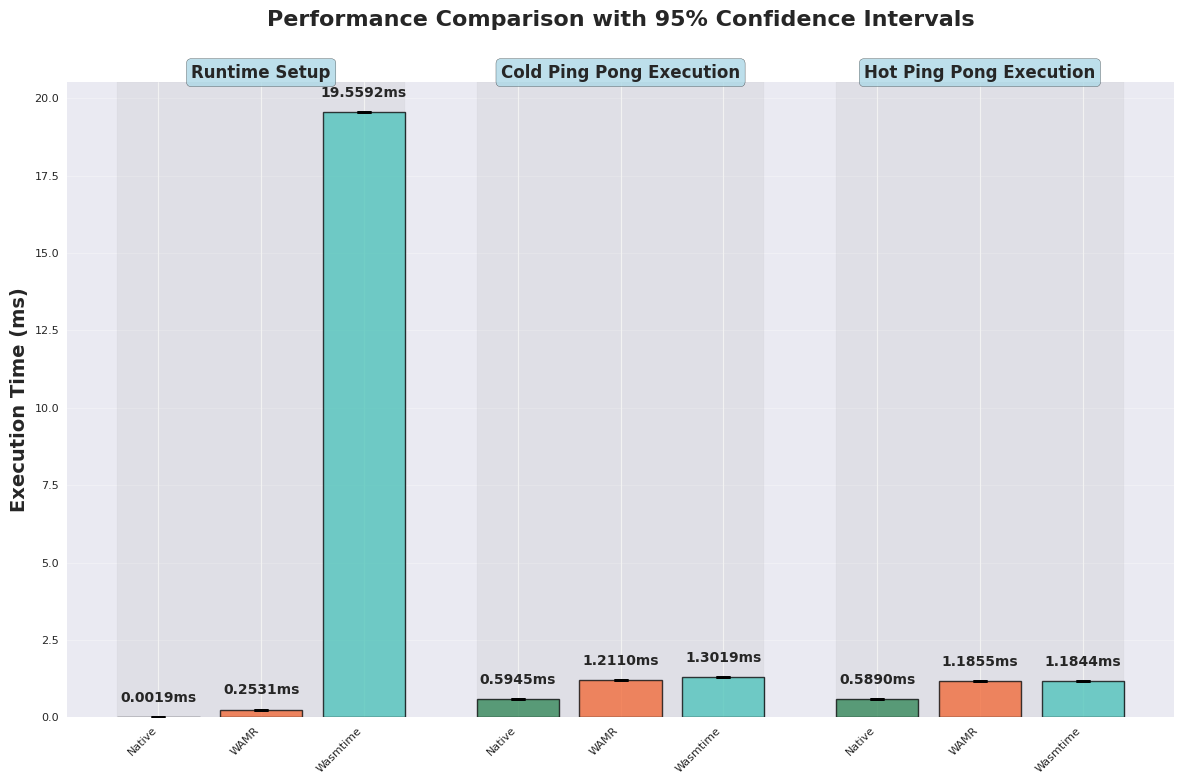

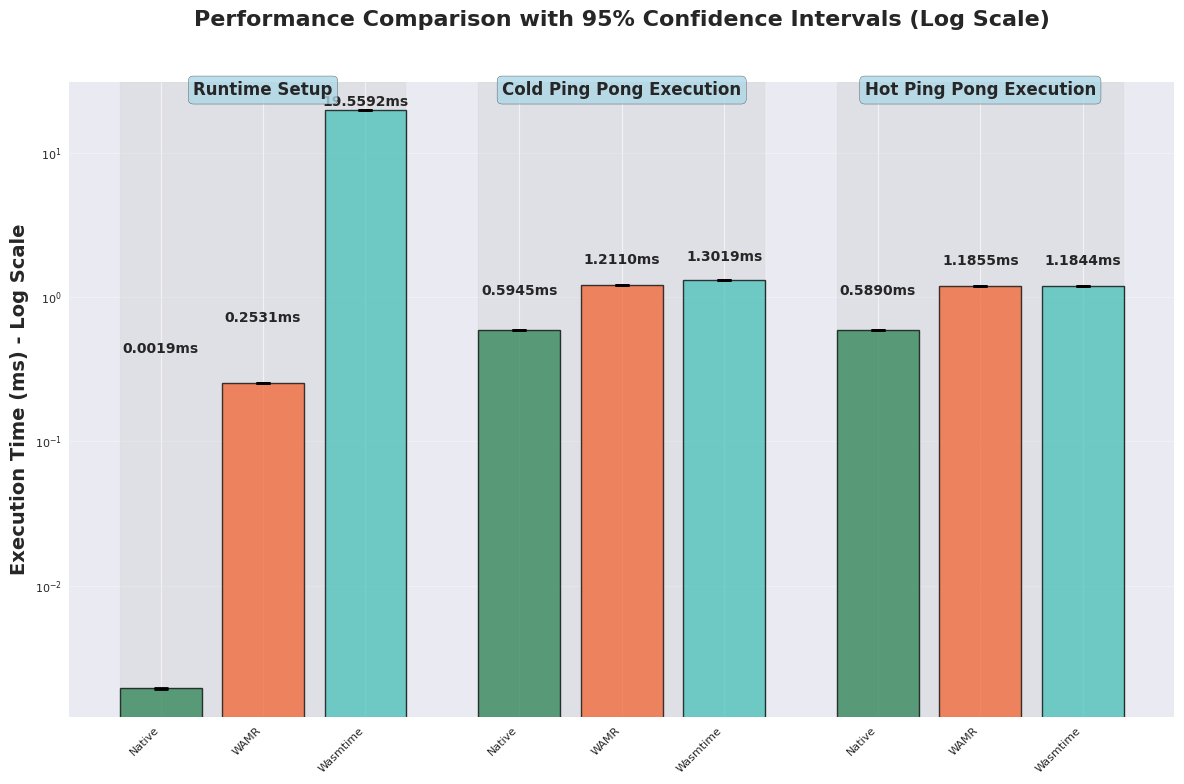

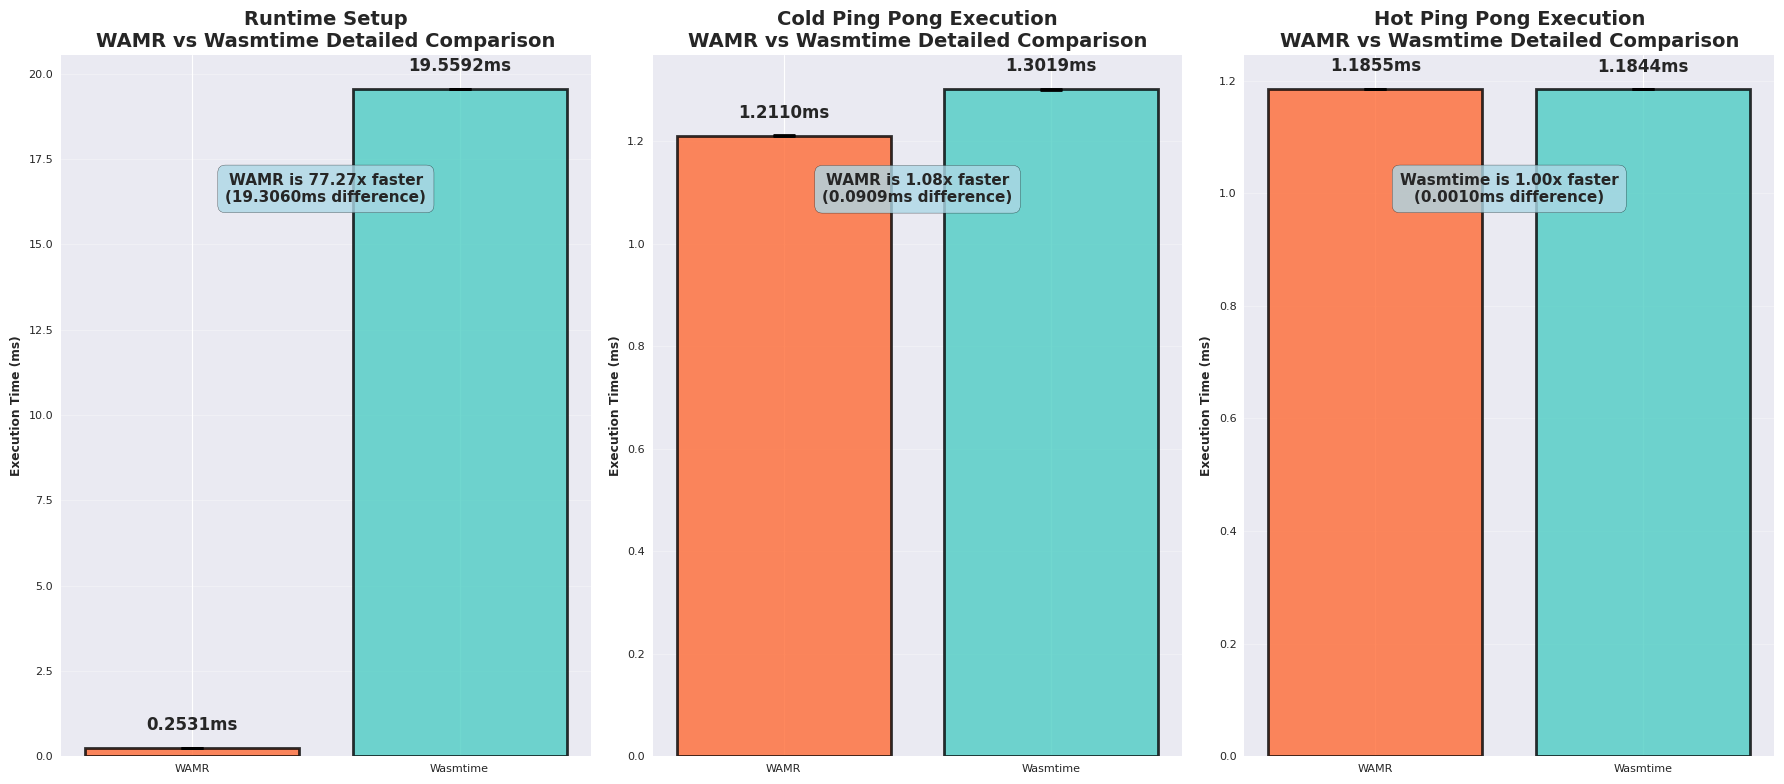

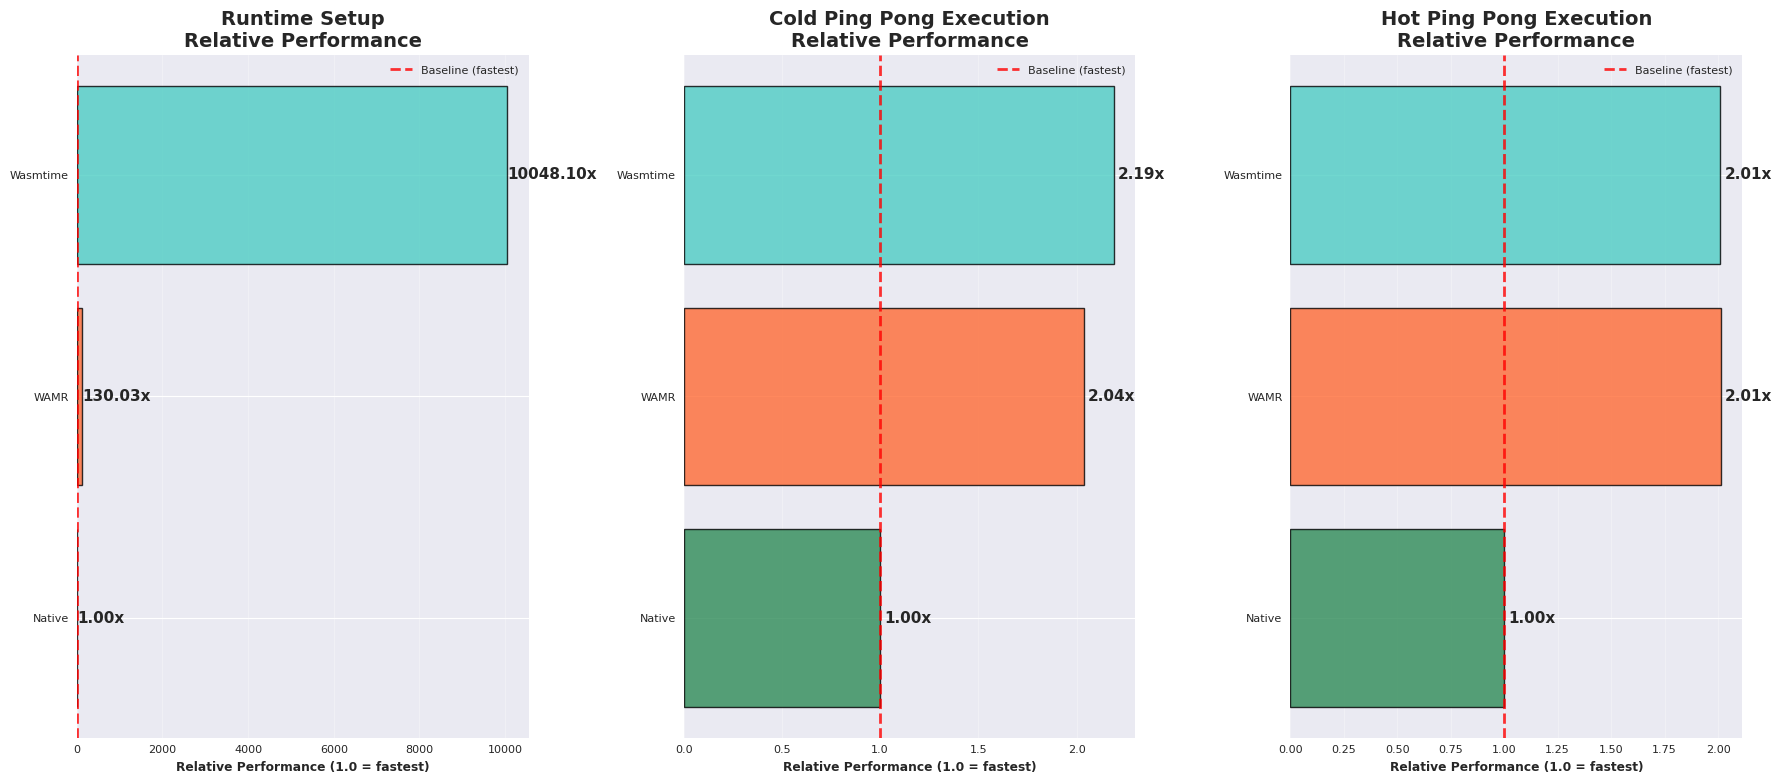

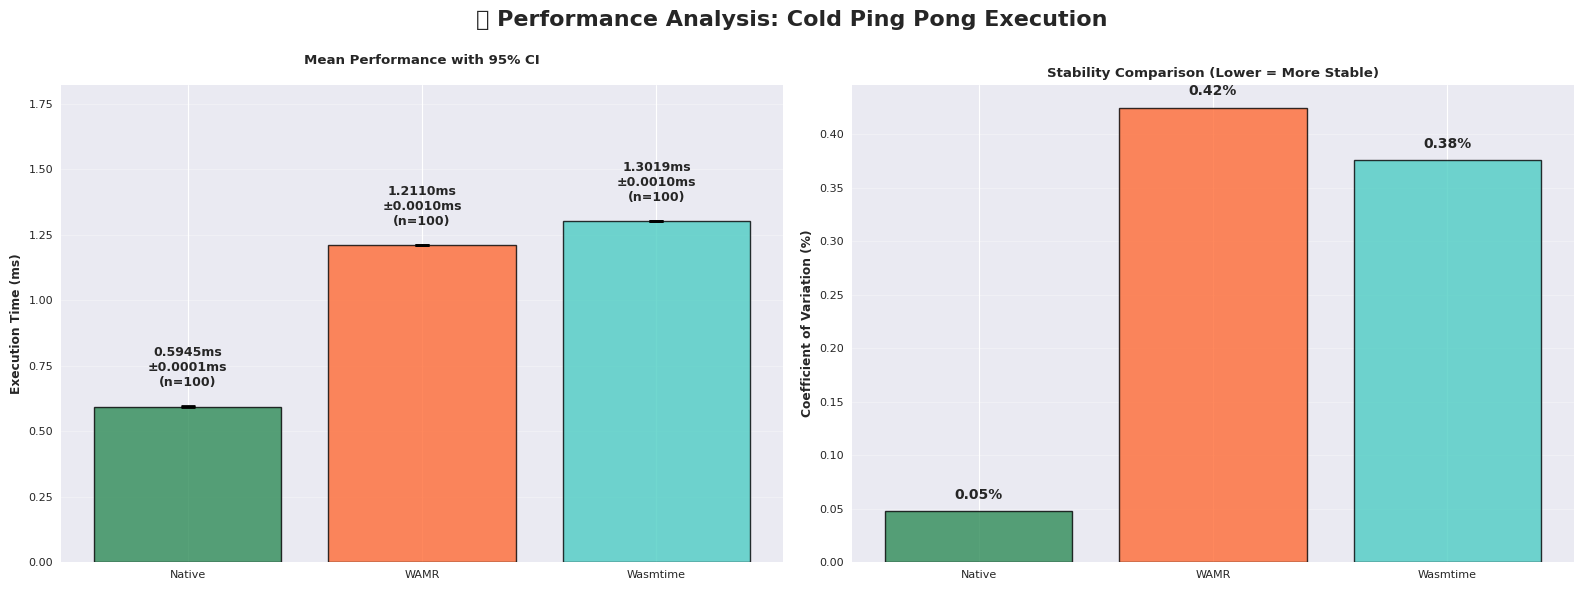

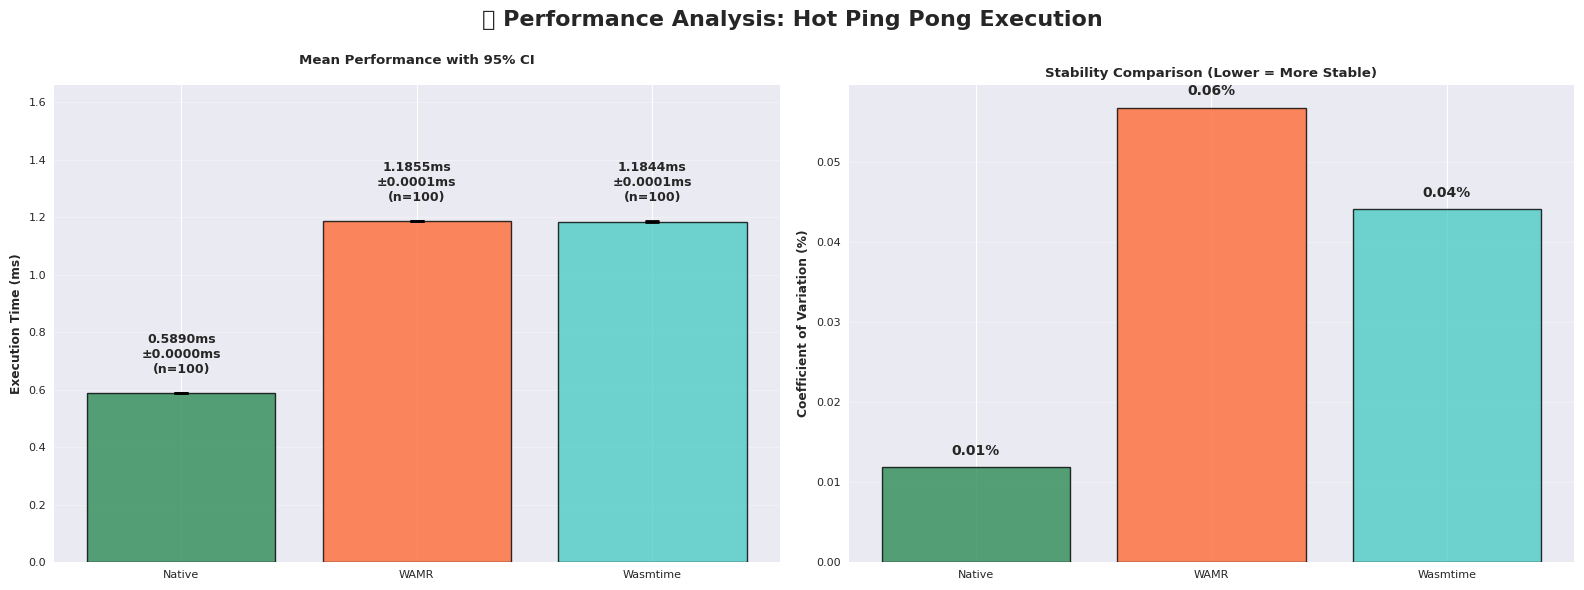

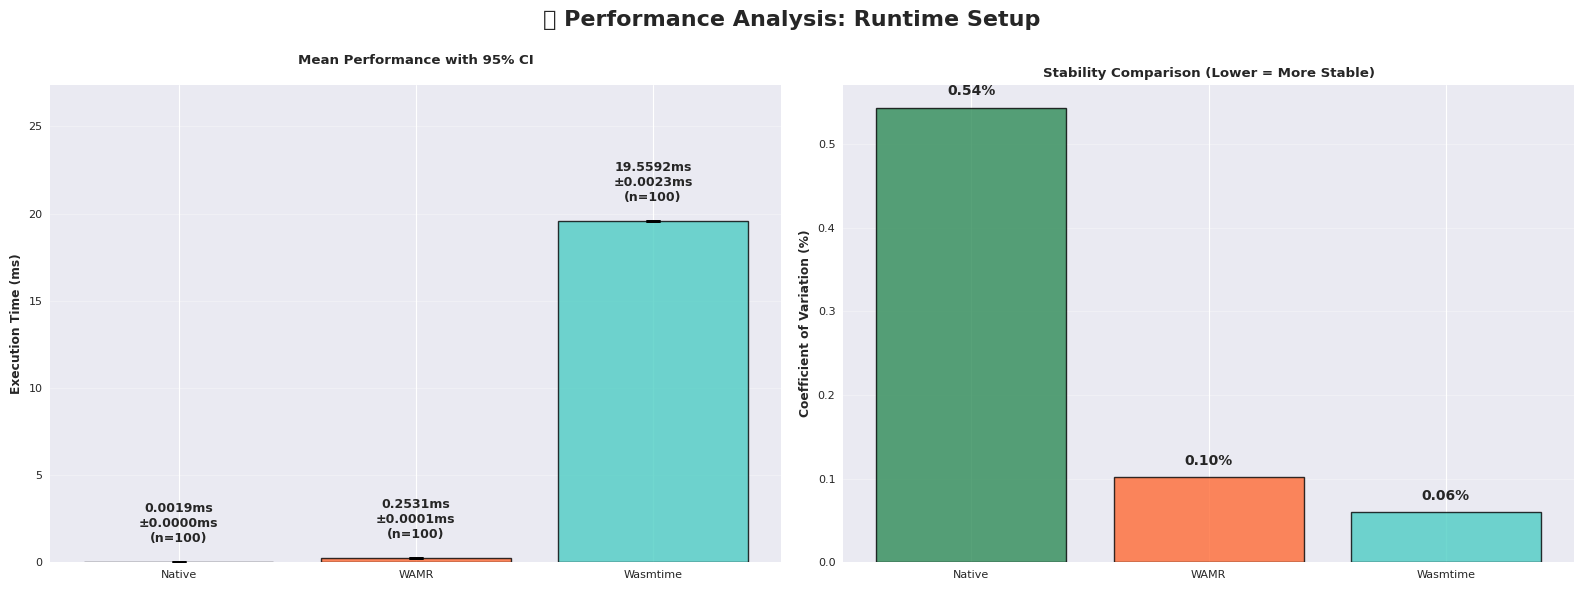

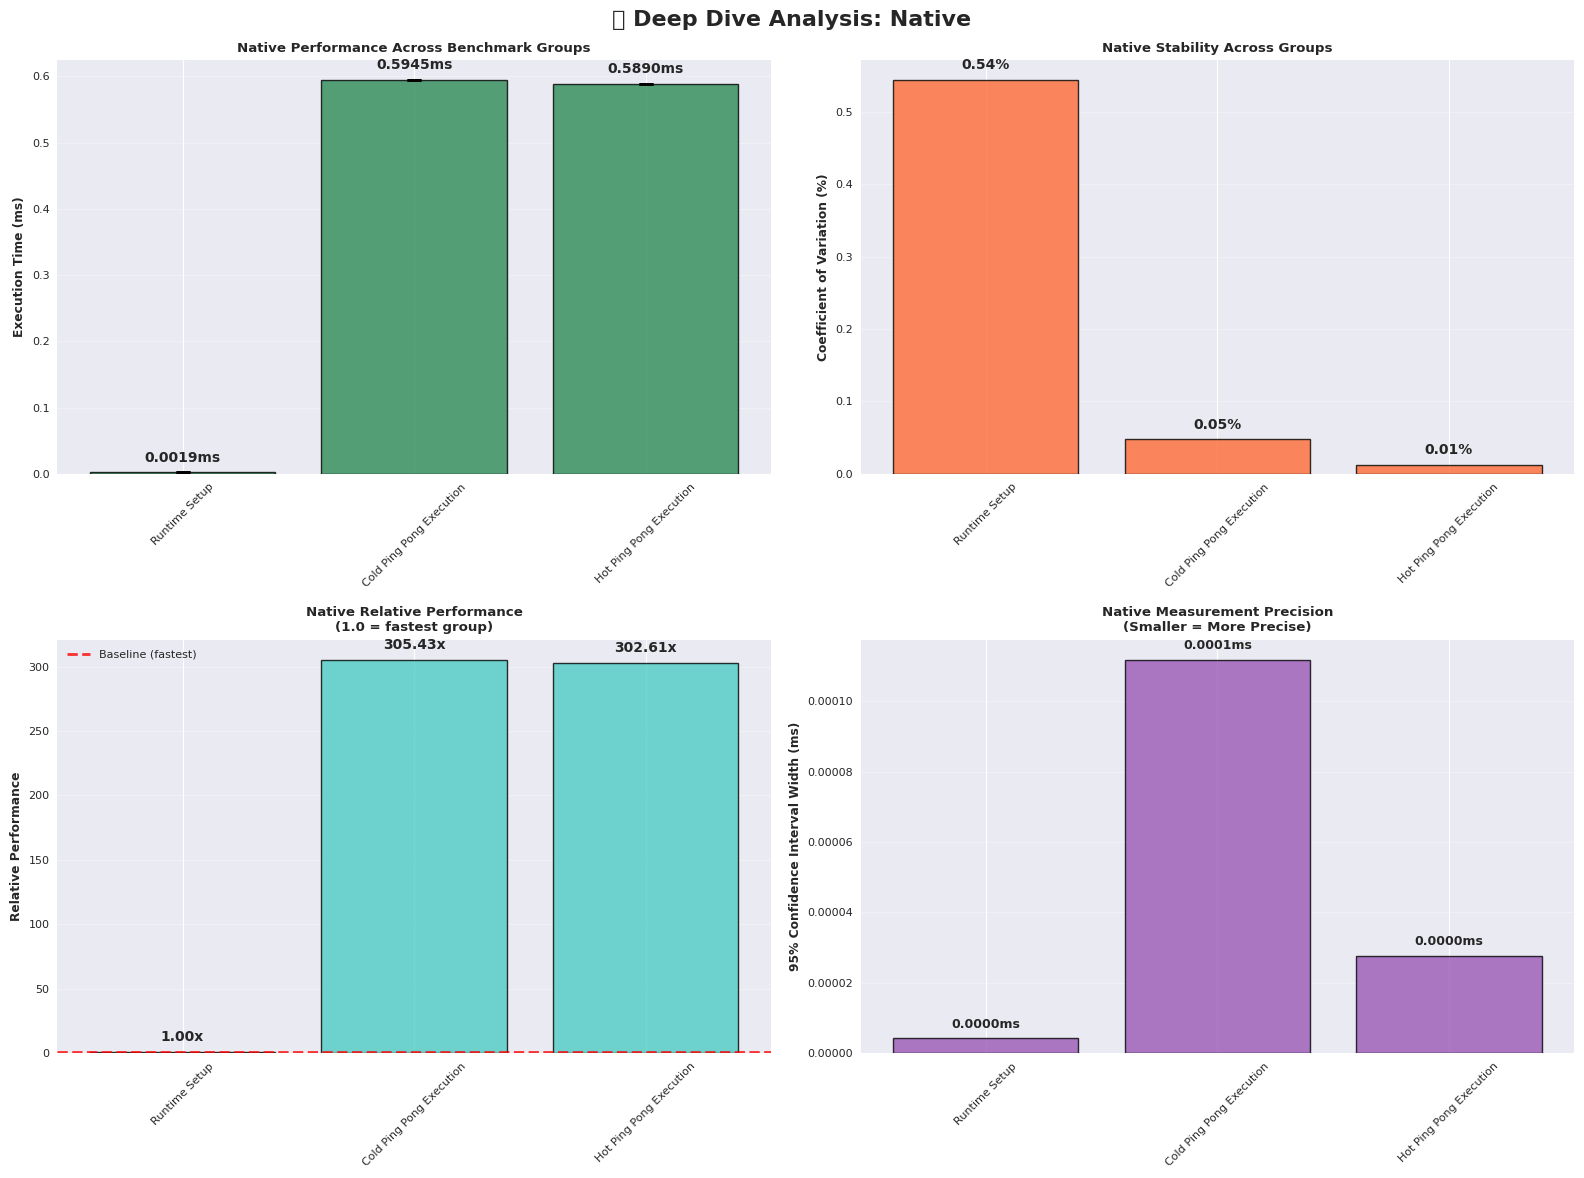

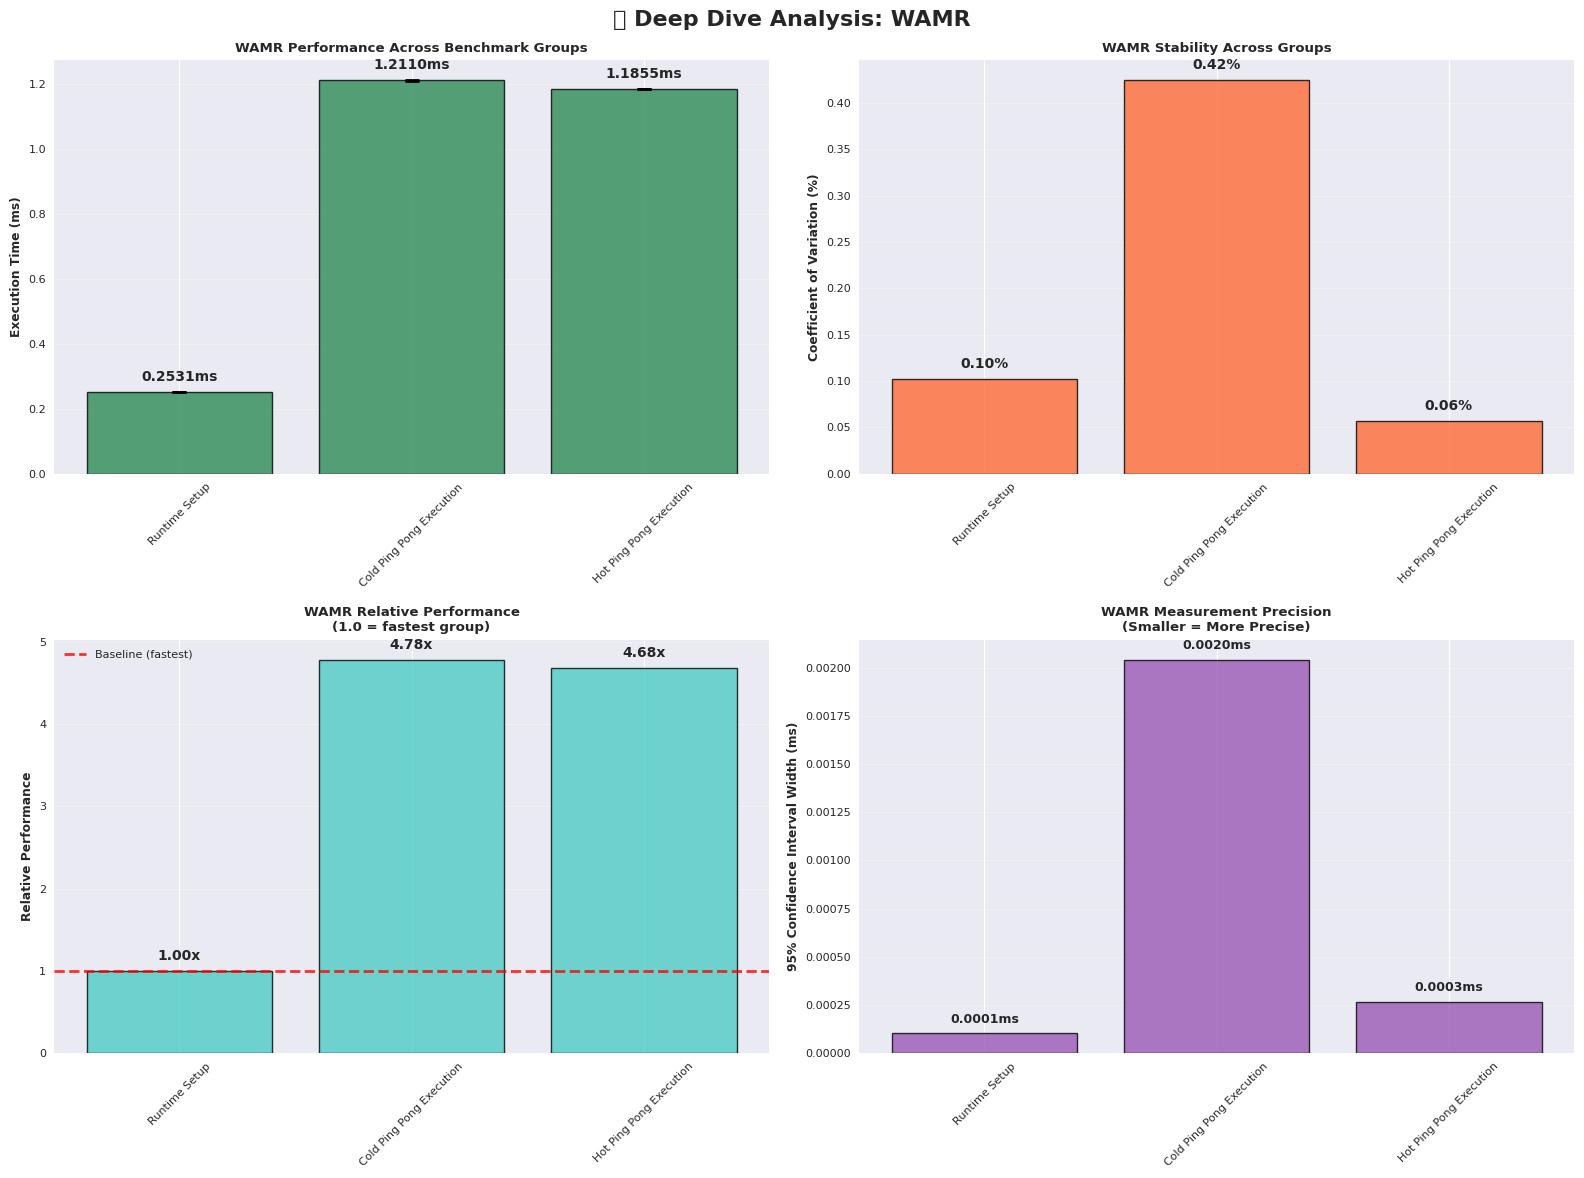

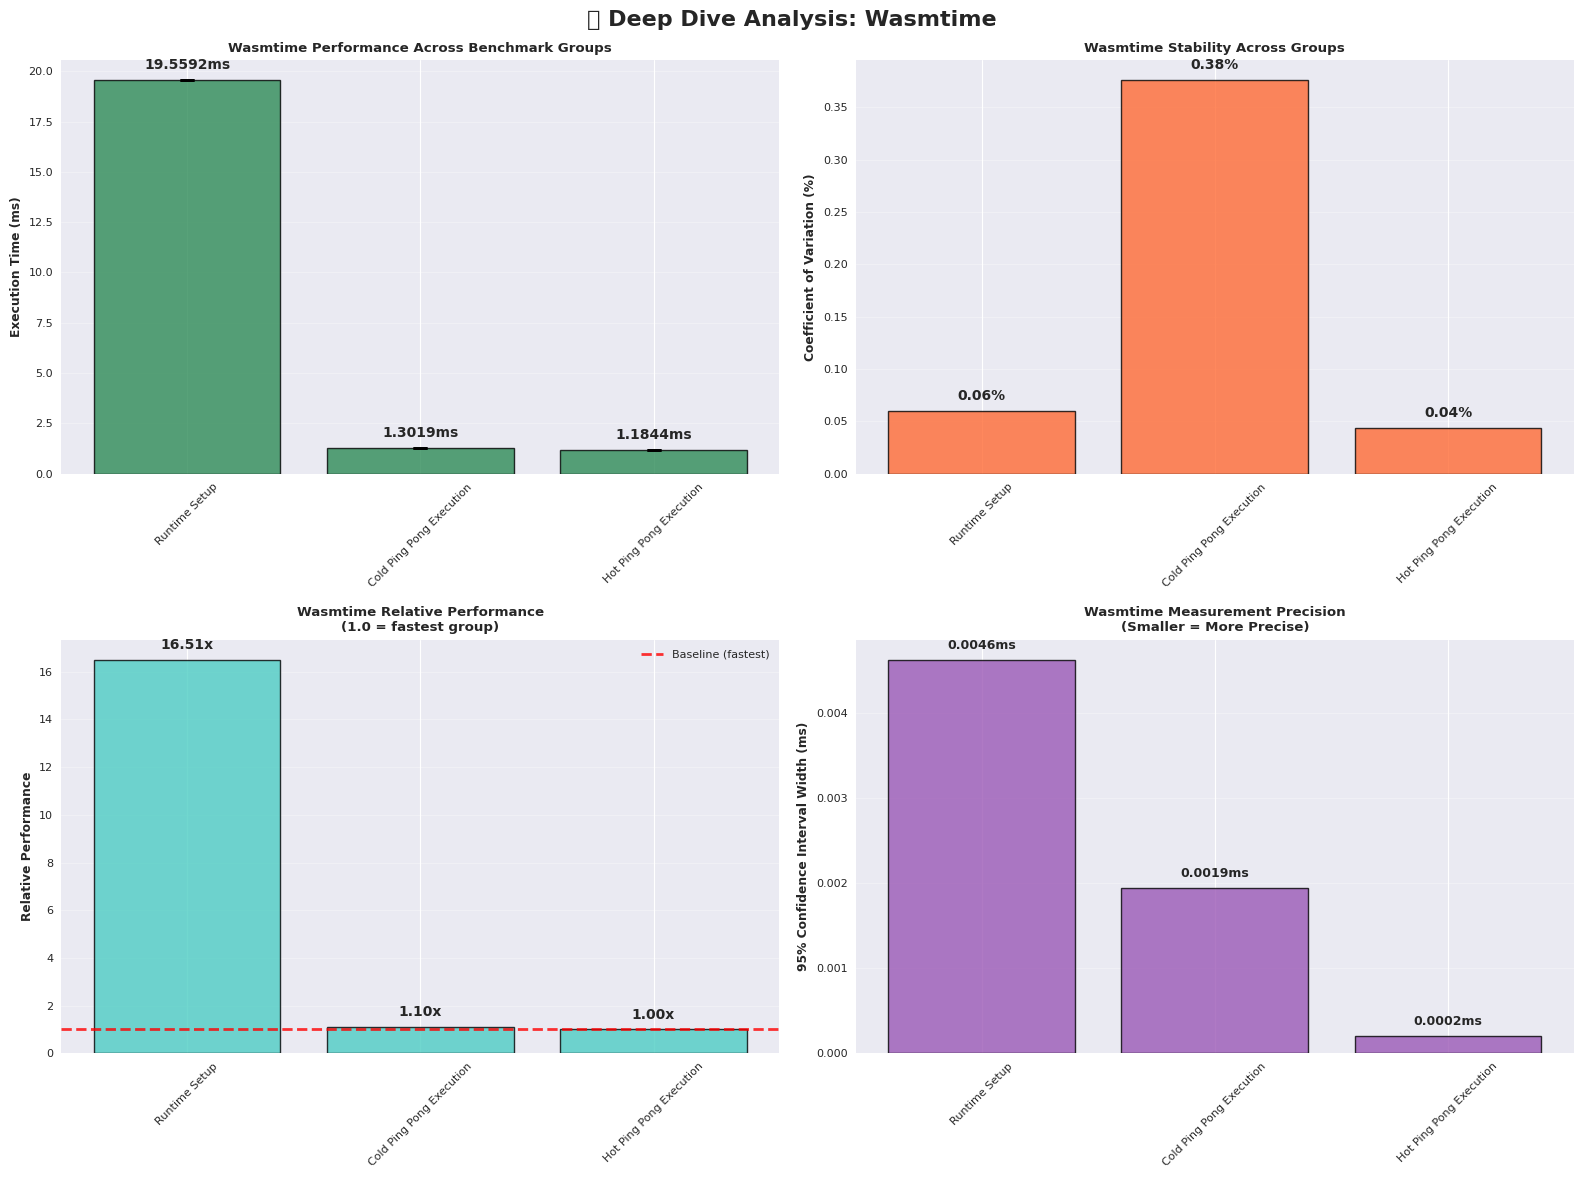

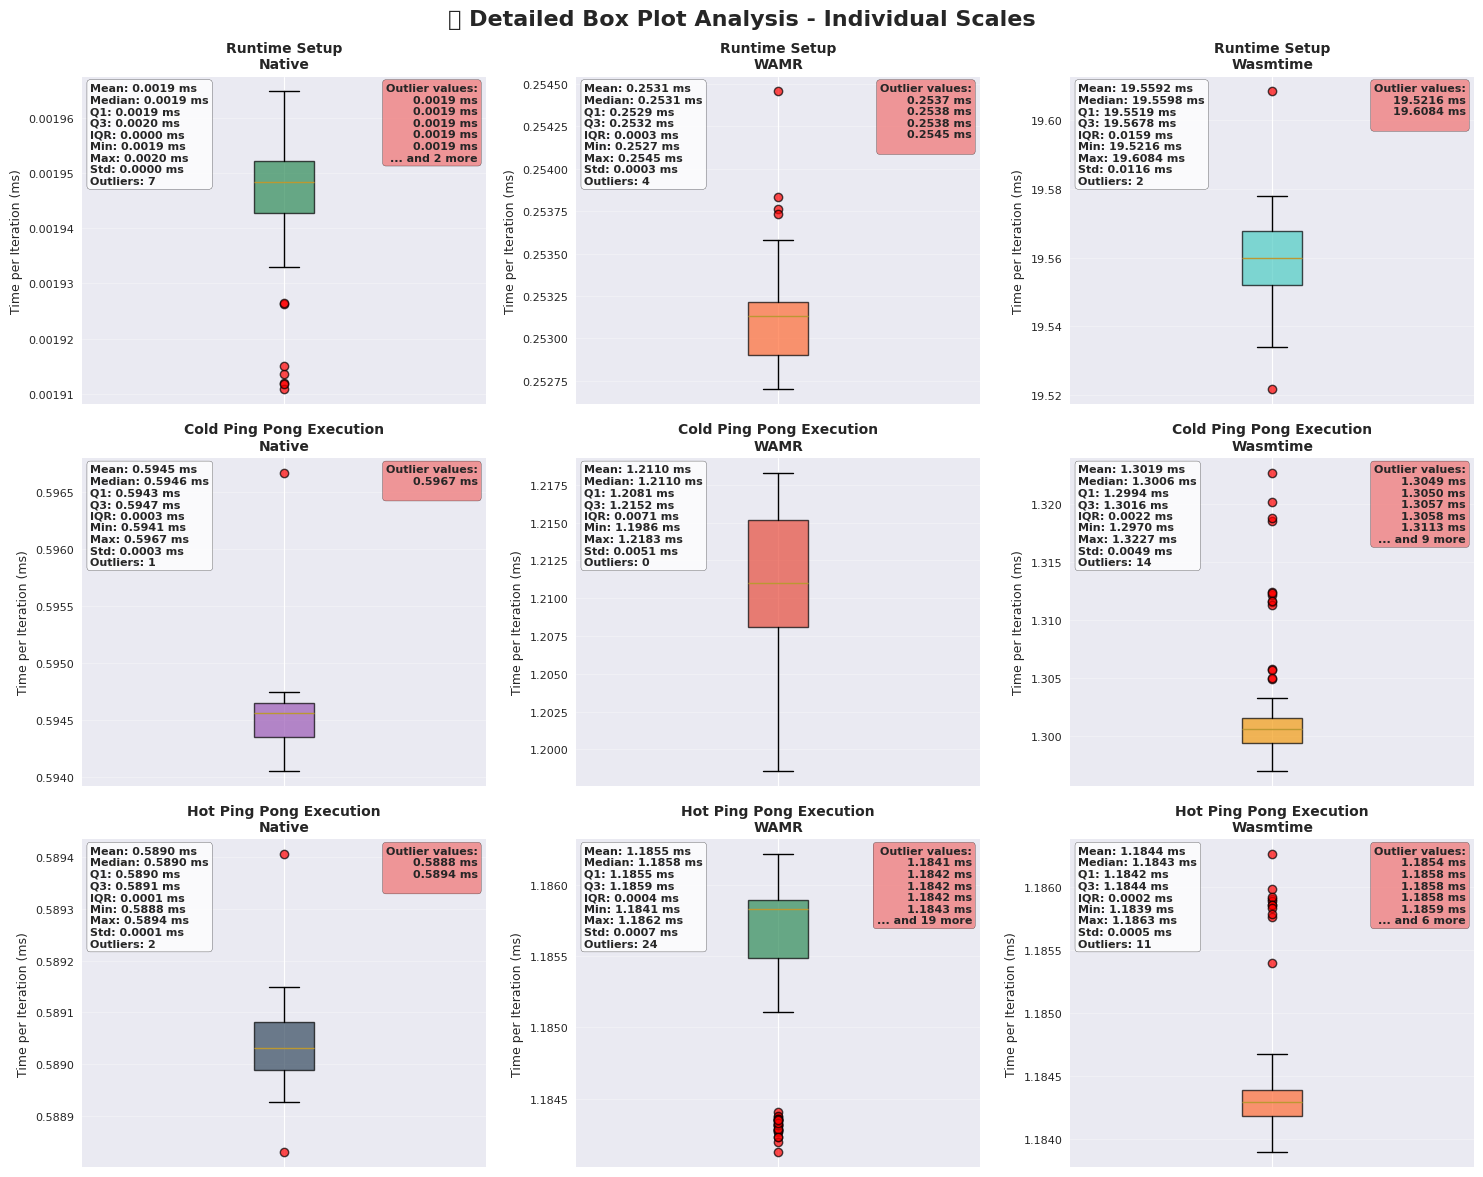

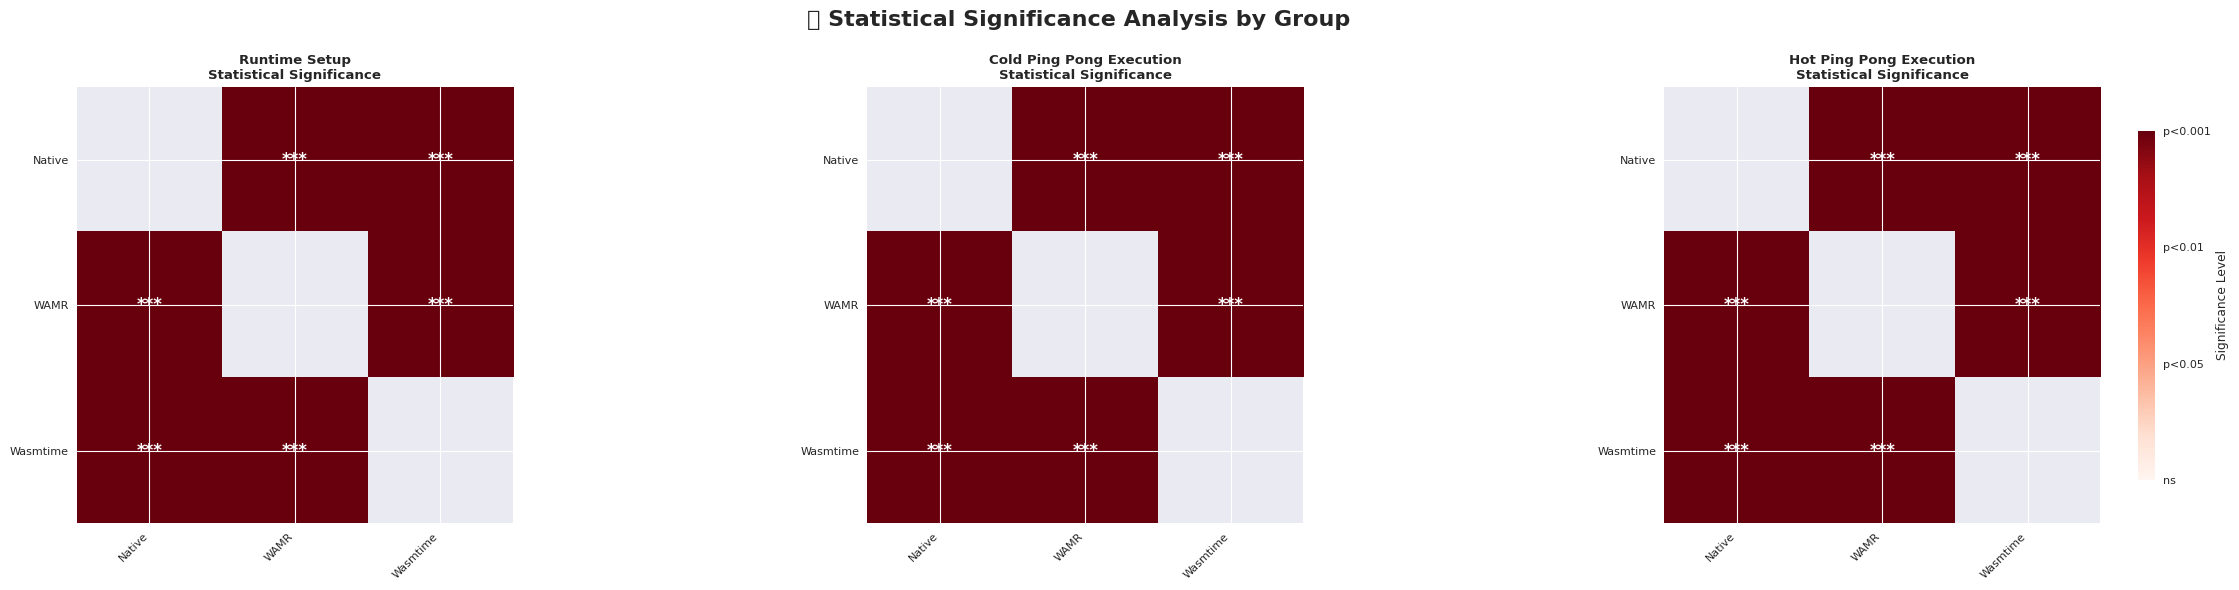

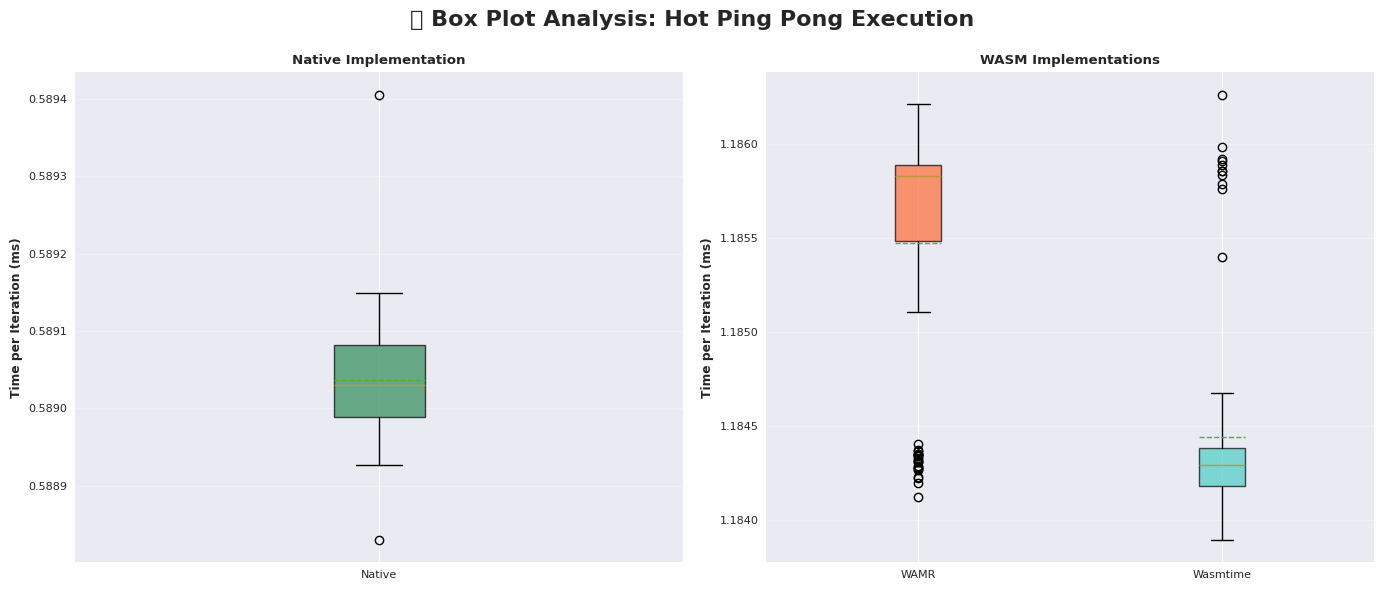

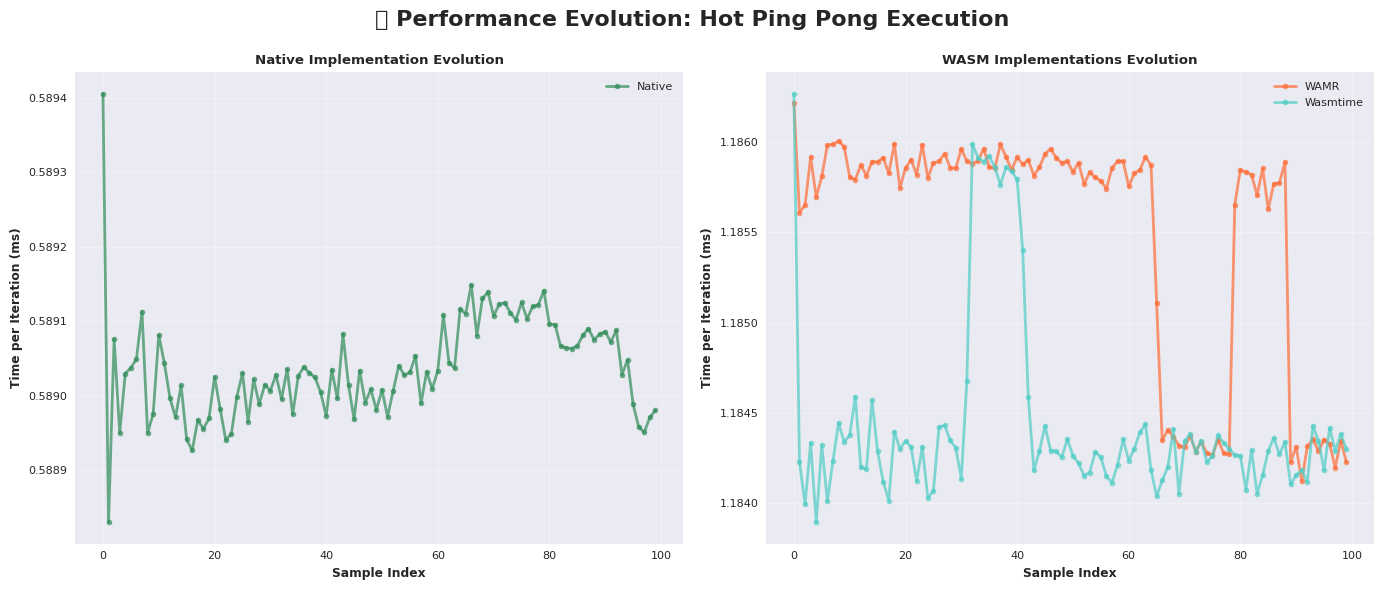

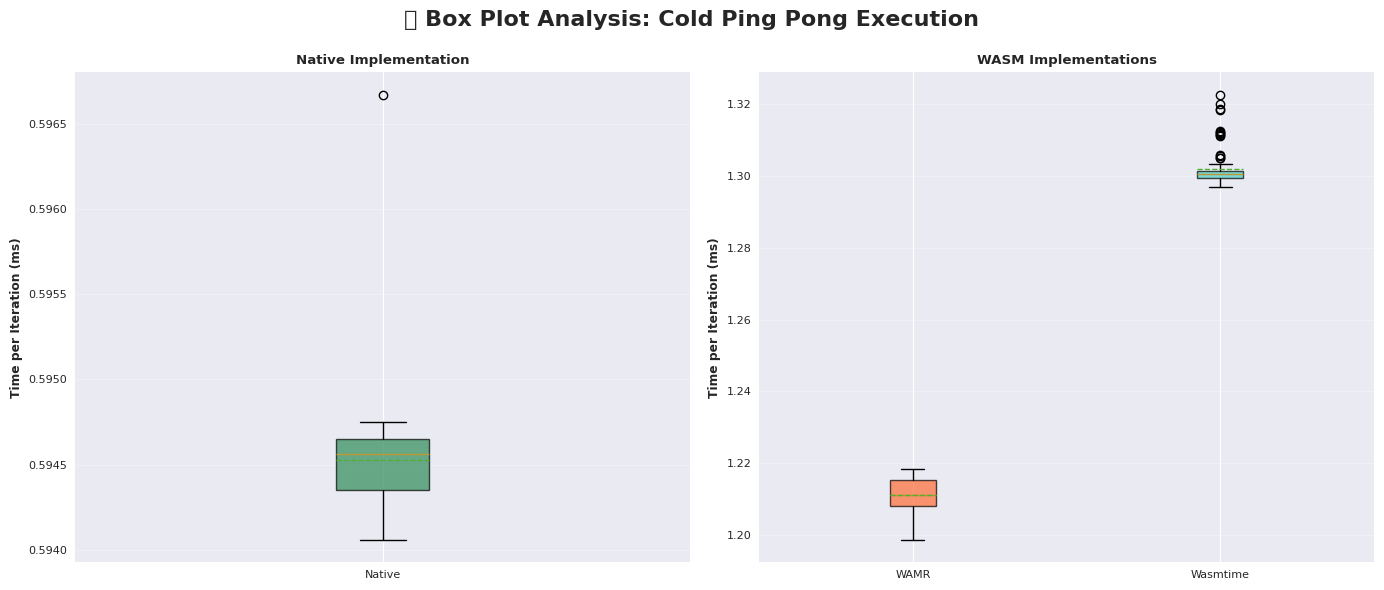

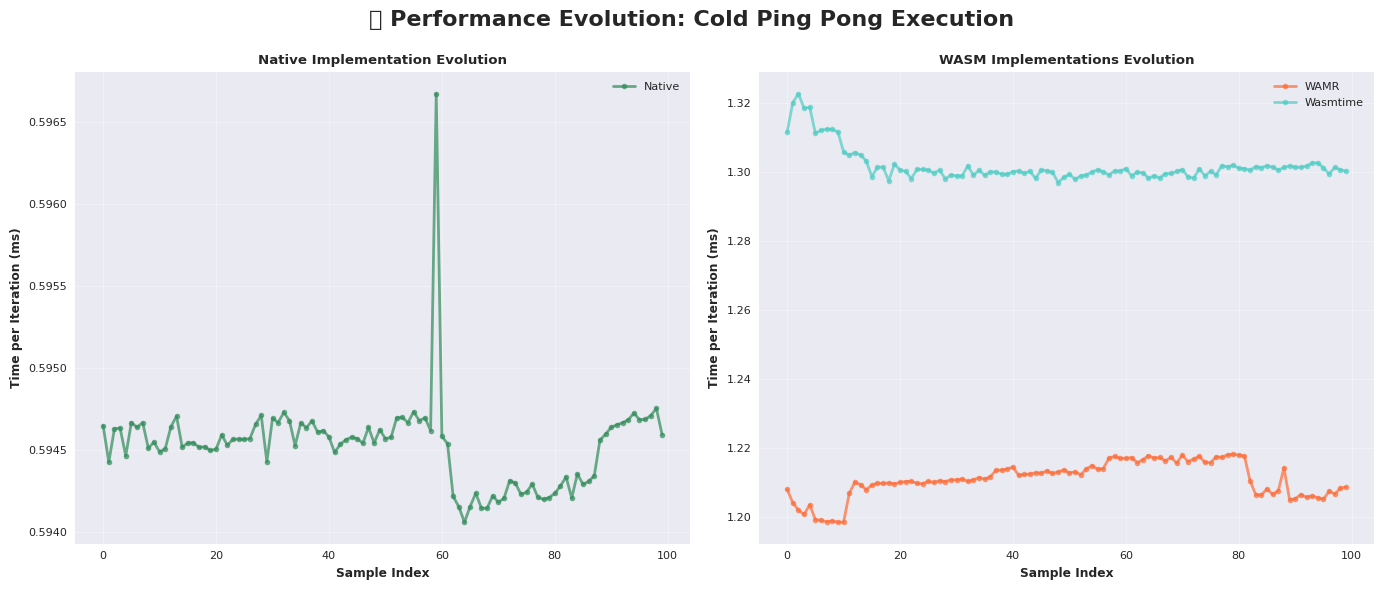

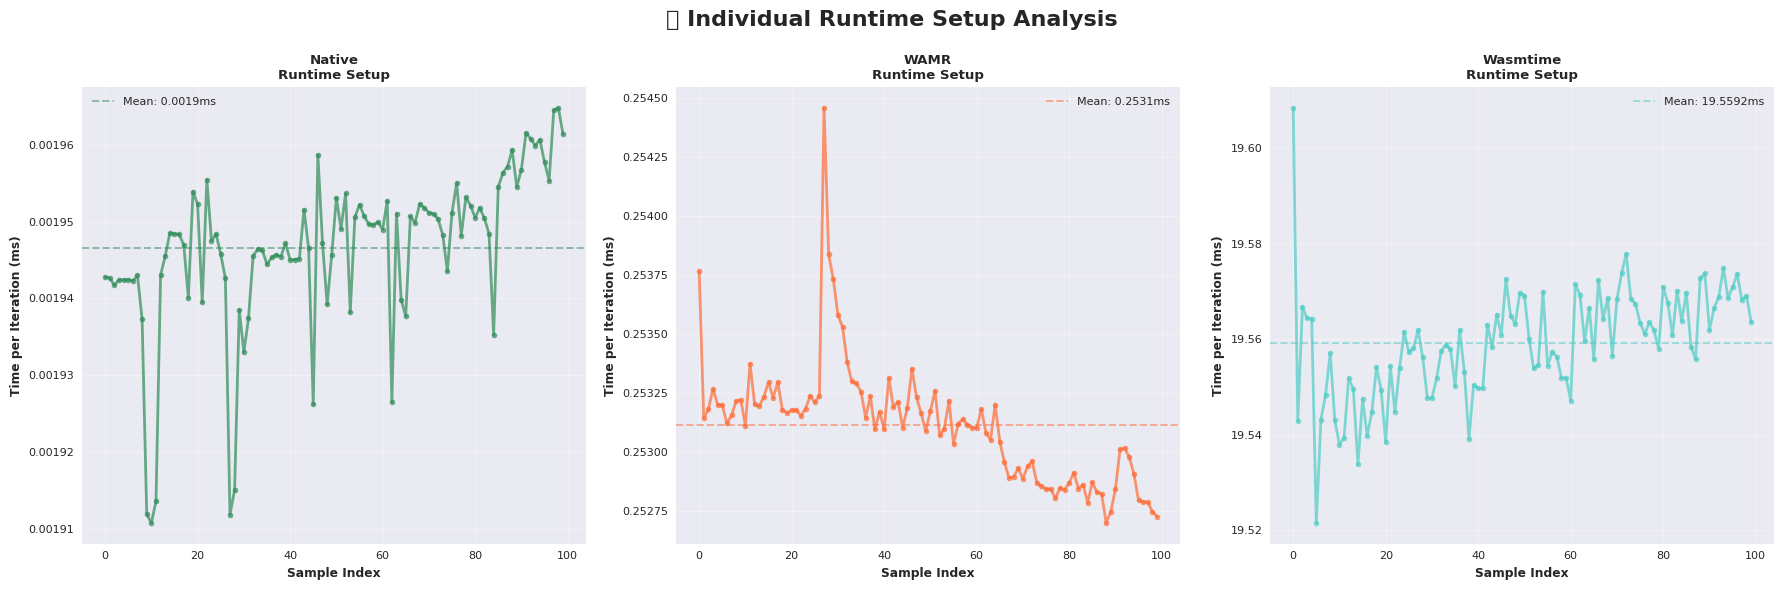

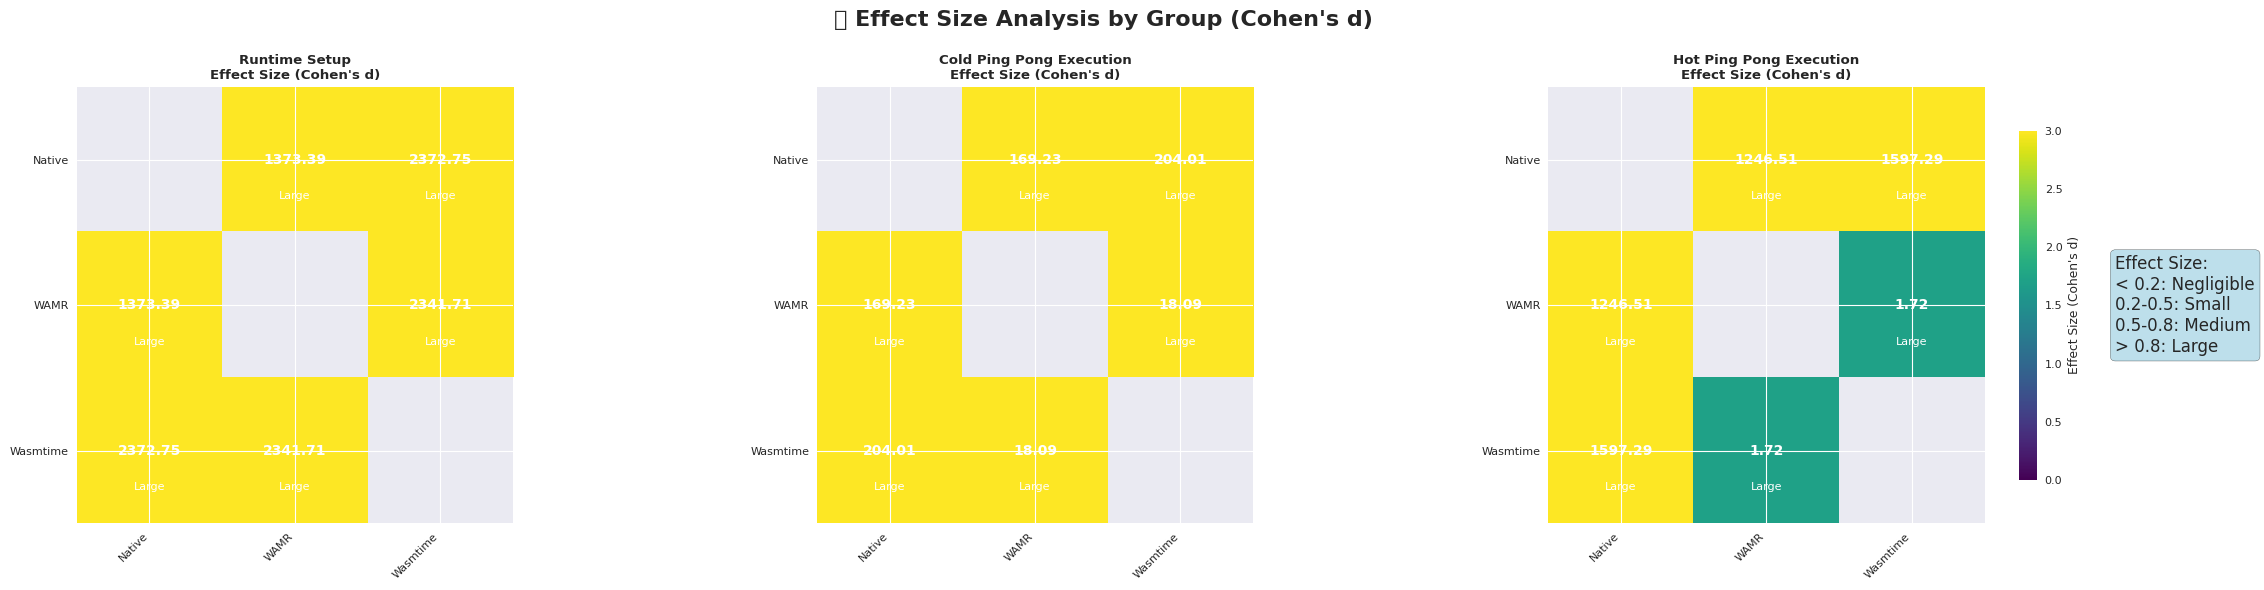

In [12]:
# Print summary
# analyzer.print_summary()

analyzer.plot_performance_comparison(log_scale=False)
analyzer.plot_performance_comparison(log_scale=True)

# Focused comparisons (perfect voor WAMR vs Wasmtime)
analyzer.plot_wamr_vs_wasmtime_focus()
analyzer.plot_relative_performance_all()

# Individual analyses
analyzer.plot_single_group_analysis("Cold Ping Pong Execution")
analyzer.plot_single_group_analysis("Hot Ping Pong Execution")
analyzer.plot_single_group_analysis("Runtime Setup")

analyzer.plot_single_implementation_analysis("Native")
analyzer.plot_single_implementation_analysis("WAMR")
analyzer.plot_single_implementation_analysis("Wasmtime")

# # Advanced analyses
analyzer.plot_outlier_analysis()
analyzer.plot_statistical_significance_matrix()

analyzer.plot_ping_pong_boxplots("Hot Ping Pong Execution")
analyzer.plot_ping_pong_evolution("Hot Ping Pong Execution")
analyzer.plot_ping_pong_boxplots("Cold Ping Pong Execution")
analyzer.plot_ping_pong_evolution("Cold Ping Pong Execution")

# Voor runtime setup
analyzer.plot_runtime_setup_individual()

# Effect size matrix
analyzer.plot_effect_size_matrix()

# Interactive plots
# analyzer.plot_interactive_comparison()
# analyzer.plot_interactive_stability()